# Set-up

In [ ]:
import jax
import jax.numpy as jnp
import jaxopt
import optax
import equinox as eqx
import diffrax
from utils.Solvers import solve, safe_solve
from utils.Tests import *
from DeepKoopman.Archs import *
import time
from typing import Any, Callable, Optional, Tuple

from icecream import ic as ice

from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [2]:
def optimize_simple(
    x: jnp.ndarray, 
    t: jnp.ndarray, 
    args_0: jnp.ndarray, 
    x0: Optional[jnp.ndarray] = None,
    max_iter: int = 1000, 
    tol: float = 1e-6, 
    optimizer_type: str = 'lbfgs', 
    lr: float = 0.001, 
    vector_field: Optional[Callable] = None, 
    ic: bool = True,
    **optimizer_kwargs: Any
) -> Tuple[jnp.ndarray, float]:
    """
    Optimize a given objective function, optionally using .run() method.

    Parameters are the same as before...
    use_run_method: Flag to use the .run() method instead of manually running update_fun.

    return: Optimized values and final loss
    """

    def loss_function(x0, ti, args, vector_field, x):
        t, xi, results = safe_solve(ti, x0, args, vector_field)
        return jax.lax.cond(jnp.all(results == diffrax.RESULTS.successful), lambda x: jnp.mean((xi - x)**2), lambda x: jnp.inf, x)
        # if jnp.any(results == 0):
        #     return jnp.mean((xi - x)**2)
        # else:
        #     return jnp.inf
        
        # return jnp.mean((xi - x)**2)

    objective_fun = lambda args: loss_function(x[0], t, args, vector_field, x) if x0 is None else loss_function(x0, t, args, vector_field, x)
    
    if ic is True:
        
        def loss_function(args_x_0, ti, vector_field, x):
            
            args, x0 = args_x_0[0], args_x_0[1]
            xi = solve(ti, x0, args, vector_field)
            
            if jnp.any(jnp.isnan(xi)):
                return jnp.inf
            
            return jnp.mean((xi - x)**2)
        
        objective_fun = lambda args_x_0: loss_function(args_x_0, t, vector_field, x)

    # Initialize optimizer based on user choice
    if optimizer_type.lower() == 'lbfgs':
        optimizer = jaxopt.LBFGS(fun=objective_fun, maxiter=max_iter, tol=tol, **optimizer_kwargs)
    elif optimizer_type.lower() == 'adam':
        opt = optax.adam(lr)
        optimizer = jaxopt.OptaxSolver(fun=objective_fun, opt=opt, maxiter=max_iter, tol=tol, **optimizer_kwargs)
    elif optimizer_type.lower() == 'gd':
        optimizer = jaxopt.GradientDescent(fun=objective_fun, maxiter=max_iter, tol=tol, **optimizer_kwargs)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    start_time = time.time()
    
    if ic is True:
        xi_final, state_final = optimizer.run(init_params=[args_0, x[0]]) if x0 is None else optimizer.run(init_params=[args_0, x0])
    else:
        xi_final, state_final = optimizer.run(init_params=args_0)
    
    end_time = time.time()
    
    print("Time elapsed: ", end_time - start_time)
    
    return xi_final

In [3]:

class SplitLikelihood():
    
    def __init__(self, key, data, times, std_dev, x0=None, K_folds=2):
        
        self.data = data[jnp.argsort(times)]
        self.times = jnp.sort(times)
        self.splits, self.splits_c = self.random_split(key, K_folds)
        # self.splits = self.splits[0].reshape(1, -1)
        # self.splits_c = self.splits_c[0].reshape(1, -1)
        
        # [plt.scatter(self.times[split], self.data[split]) for split in self.splits]
        # plt.show()
        self.MLEs = None
        self.total_MLE = None
        self.x0 = x0
        self.std_dev = std_dev
        
    
    def random_split(self, key, K_folds=1):
        total_points = self.data.shape[0]
        shuffled_indices = jax.random.permutation(key, jnp.arange(total_points))
        num_per_fold = total_points // K_folds

        fold_indices = [shuffled_indices[i * num_per_fold: (i + 1) * num_per_fold] for i in range(K_folds)]
        complement_indices = [jnp.setdiff1d(shuffled_indices, fold) for fold in fold_indices]

        return jnp.array(fold_indices), jnp.array(complement_indices)

        
    def get_MLE(self, field, w0, x0, split, max_iter=1000, tol=1e-6, optimizer_type='adam', lr=0.01, ic=False):
       
        t = self.times[split]
        data = self.data[split][jnp.argsort(t)]
        t=jnp.sort(t)

        return optimize_simple(
                data, 
                t, 
                x0=self.x0,
                args_0=w0, 
                max_iter=max_iter,
                tol=tol, 
                optimizer_type=optimizer_type, 
                lr=lr, 
                vector_field=field, 
                ic = ic)
    
    @staticmethod
    def exclude(array, idx):
        mask = jnp.ones_like(array, dtype=bool).at[idx].set(False)
        return array[mask]
    
    def fit(self, field, w0, max_iter=1000, tol=1e-6, optimizer_type='adam', lr=0.01):
        
        self.MLEs = jax.vmap(self.get_MLE, in_axes=[None, None, None, 0, None, None, None, None])(field, w0, self.x0, self.splits, max_iter, tol, optimizer_type, lr)
        
        self.MLE = self.get_MLE(field, w0, self.x0, jnp.arange(len(self.data)), max_iter, tol, optimizer_type, lr)
        ice(self.MLE)
        
        self.cross_L = jax.vmap(self.cross_likelihood_, in_axes=[None, 0, 0])(field, self.MLEs, self.splits_c)
    
    @staticmethod
    def likelihood(data, traj, split, std_dev):
        """
        Calculate the Gaussian likelihood of the data given a trajectory and noise variance.

        Parameters:
        - data: The observed data points.
        - traj: The expected trajectory (mean values).
        - split: Indices or boolean mask to select the data points to be included in the calculation.
        - variance: The variance of the Gaussian noise.

        Returns:
        - The likelihood of the selected data points.
        """
        
        selected_data = data[split]
        selected_traj = traj[split]

        # Calculate the Gaussian likelihood for each data point
        likelihoods = jax.scipy.stats.norm.pdf(selected_data, loc=selected_traj, scale=std_dev)

        # Multiply the likelihoods of all data points
        total_likelihood = jnp.prod(likelihoods)

        return total_likelihood
    
    def c_likelihood(self, field, t, x0, w, x):
        x_pred = solve(t, x0, w, field) 
        return self.likelihood(x, x_pred, self.splits_c, self.std_dev)

    def cross_likelihood_(self, field, MLE, c_split):
        x_pred = solve(self.times, self.x0, MLE, field) 
        return self.likelihood(self.data, x_pred, c_split, self.std_dev)
    
    @eqx.filter_jit
    def log_Tn(self, field, w):
        
        traj = solve(self.times, self.x0, w, field)
        likelihoods_top = jax.vmap(self.likelihood, in_axes=[None, None, 0, None])(self.data, traj, self.splits_c, self.std_dev)
        
        return jnp.log(jnp.mean(self.cross_L/likelihoods_top))
    
    def get_full_CI(self, field, alpha=0.05, delta_upper=[20, 20], delta_lower=[20, 20], num_points=20, plot_grid=False):
        import matplotlib.colors as mcolors
        import matplotlib.pyplot as plt
        import jax.numpy as jnp

        avg_mle = jnp.array([60, 30.4])
        
        # Define the grid resolution for each parameter
        dx = (delta_upper[0] + delta_lower[0]) / num_points
        dy = (delta_upper[1] + delta_lower[1]) / num_points

        # Generate the grid
        x, y = jnp.mgrid[slice(avg_mle[0] - delta_lower[0], avg_mle[0] + delta_upper[0] + dx, dx),
                        slice(avg_mle[1] - delta_lower[1], avg_mle[1] + delta_upper[1] + dy, dy)]

        x_flat, y_flat = x.flatten(), y.flatten()

        # Compute SLR values
        slr_values = jax.vmap(lambda params: self.log_Tn(field, params))(jnp.column_stack((x_flat, y_flat)))
        z = slr_values.reshape(x.shape)

        # Calculate the threshold
        threshold = jnp.log(1 / alpha)

        # Identify parameters with SLR values under the threshold
        under_threshold = z < threshold
        params_under_threshold = jnp.column_stack((x[under_threshold], y[under_threshold]))

        if plot_grid:
            fig, ax = plt.subplots()
            # qm = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
            ax.contour(x, y, z, levels=[threshold], colors='red', linewidths=2)
            ax.set_title('SLR Heatmap Visualization')
            # fig.colorbar(qm, ax=ax)
            plt.xlabel('Parameter 1')
            plt.ylabel('Parameter 2')
            plt.show()

        return params_under_threshold
    
    def get_full_CI(self, field, alpha=0.05, delta_upper=[20, 20], delta_lower=[20, 20], num_points=20, plot_grid=False):
        import matplotlib.colors as mcolors
        import matplotlib.pyplot as plt
        import jax.numpy as jnp

        avg_mle = jnp.array([60, 30.4])
        
        # Generate grids for each dimension
        grids = [jnp.linspace(avg_mle[i] - delta_lower[i], avg_mle[i] + delta_upper[i], num_points) for i in range(len(avg_mle))]

        # Generate a meshgrid (note: this may need adjustment for dimensions > 2)
        mesh = jnp.meshgrid(*grids, indexing='ij')

        # Flatten the meshgrid to create a list of parameter combinations
        param_combinations = jnp.stack([m.flatten() for m in mesh], axis=-1)

        # Compute SLR values
        slr_values = jax.vmap(lambda params: self.log_Tn(field, params))(param_combinations)
        z = slr_values.reshape([num_points] * len(avg_mle))

        # Calculate the threshold
        threshold = jnp.log(1 / alpha)

        # Identify parameters with SLR values under the threshold
        under_threshold = z < threshold
        params_under_threshold = param_combinations[under_threshold.flatten()]

        return params_under_threshold

    def get_SLR_mask(self, field, alpha=0.05, delta_upper=[20, 20], delta_lower=[20, 20], num_points=20):
        import matplotlib.pyplot as plt
        import jax.numpy as jnp

        avg_mle = jnp.array([60, 30.4])
        
        # Define the grid resolution for each parameter
        dx = (delta_upper[0] + delta_lower[0]) / num_points
        dy = (delta_upper[1] + delta_lower[1]) / num_points

        # Generate the grid
        x, y = jnp.mgrid[slice(avg_mle[0] - delta_lower[0], avg_mle[0] + delta_upper[0] + dx, dx),
                        slice(avg_mle[1] - delta_lower[1], avg_mle[1] + delta_upper[1] + dy, dy)]

        x_flat, y_flat = x.flatten(), y.flatten()

        # Compute SLR values for each grid point
        slr_values = jax.vmap(lambda params: self.log_Tn(field, params))(jnp.column_stack((x_flat, y_flat)))
        # z = slr_values.reshape(x.shape)

        # Calculate the threshold
        threshold = jnp.log(1 / alpha)

        # Create a binary 2D array for contour plotting
        z = jnp.where(slr_values.reshape(x.shape) < threshold, 1, 0)

        return z
    
    def compare_CI(self, other, field, delta_upper, delta_lower, alpha=0.05, num_points=20, mle=None, plot=False):
        import itertools
        import numpy as np
        # Ensure the MLE is set
        avg_mle = self.MLE if mle is None else mle
        # Number of parameters
        print(avg_mle.shape)
        num_params = len(avg_mle)
        
        # Generate grids for each dimension
        grids = [jnp.linspace(avg_mle[i] - delta_lower[i], avg_mle[i] + delta_upper[i], num_points) for i in range(len(avg_mle))]

        mesh = jnp.meshgrid(*grids, indexing='ij')
        
        # Flatten the meshgrid to create a list of parameter combinations
        param_combinations = jnp.stack([m.flatten() for m in mesh], axis=-1)

        slr_values_self = jax.vmap(lambda params: self.log_Tn(field, params))(param_combinations)
        slr_values_other = jax.vmap(lambda params: other.log_Tn(field, params))(param_combinations)
        
        slr_values_self = slr_values_self.reshape([num_points] * num_params)
        slr_values_other = slr_values_other.reshape([num_points] * num_params)
        
        ice(slr_values_self.shape, slr_values_other.shape)
        # Calculate the threshold
        threshold = jnp.log(1 / alpha)

        # Identify parameters with SLR values under the threshold
        under_threshold_self = slr_values_self < threshold
        under_threshold_other = slr_values_other < threshold
        
        params_self = jnp.column_stack([m[under_threshold_self] for m in mesh])
        params_other = jnp.column_stack([m[under_threshold_other] for m in mesh])

        if plot:
            
            if num_params == 1:
                # For single-dimensional parameters, plot intervals on a line
                fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
                peg_size = 30  # Adjust the size as needed

                # Plot the intervals for other
                ax.plot([params_other[0], params_other[-1]], [0, 0], color='red', linewidth=2, label='Equidistant Design')
                ax.scatter([params_other[0], params_other[-1]], [0, 0], color='red', s=peg_size, marker="|")

                # Plot the intervals for self

                ax.plot([params_self[0], params_self[-1]], [0, 0], color='forestgreen', linewidth=2,label='Experimental Design')
                ax.scatter([params_self[0], params_self[-1]], [0, 0], color='forestgreen', s=peg_size, marker="|")

                # Mark the MLE point
                ax.scatter(avg_mle, 0, marker='s', color='black', label='The true parameter')

                # Set labels and titles
                ax.set_xlabel('Parameter Value')
                ax.set_title('95% Confidence Interval')

                # Add pegs at the ends of the intervals

                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['right'].set_visible(False)
                # Hide left border (spine)
                plt.gca().spines['left'].set_visible(False)
                
                # Add a legend
                ax.legend(frameon=False)
                ax.yaxis.set_visible(False)
                plt.tight_layout()
                plt.show()

            else:
                # Number of plots required for the upper triangle (excluding the diagonal)
                num_plots = num_params * (num_params - 1) // 2

                # Determine the number of rows and columns for subplots
                num_rows = int(jnp.ceil(jnp.sqrt(num_plots)))
                num_cols = int(jnp.ceil(num_plots / num_rows))

                # Create a figure with subplots
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5), dpi=300)
                if not isinstance(axes, np.ndarray):
                    axes = [axes]  # Wrap it in a list for consistency
                else:
                    axes = axes.flatten()  # Flatten the axes array for easy indexing


                plot_index = 0  # Index to keep track of which subplot to use next

                for i, j in itertools.product(range(num_params), repeat=2):
                    if i >= j:  # Skip redundant plots (lower triangle)
                        continue  # Only plot upper triangle (excluding diagonal)

                    ax = axes[plot_index]
                    plot_index += 1
                    # ice(slr_values_self[..., [i, j]].shape, slr_values_other[..., [i, j]].shape, mesh[i].shape, mesh[j].shape)

                    # Plot contour for the current object
                    ax.contour(mesh[i], mesh[j], slr_values_self, levels=[threshold], colors='forestgreen', linewidths=2)
                    # Plot contour for the other object
                    ax.contour(mesh[i], mesh[j], slr_values_other, levels=[threshold], colors='red', linewidths=2)

                    # Set labels and titles
                    ax.set_xlabel(f'Parameter {i+1}')
                    ax.set_ylabel(f'Parameter {j+1}')

                # Remove unused subplots (if any)
                for k in range(plot_index, num_rows * num_cols):
                    fig.delaxes(axes[k])


                # Mark the MLE point
                ax.scatter(avg_mle[0], avg_mle[1], marker='s', color='black')
                
                # Add a legend and adjust layout
                # plt.gca().spines['top'].set_visible(False)
                # plt.gca().spines['right'].set_visible(False)
                
                fig.suptitle('95% Confidence Intervals', fontsize=14)
                
                                # Create a legend
                green_line = matplotlib.lines.Line2D([], [], color='forestgreen', linewidth=2, label='Bayesian Experimental Design')
                red_line = matplotlib.lines.Line2D([], [], color='red', linewidth=2, label='Equidistant Design')
                black_marker = matplotlib.lines.Line2D([], [], color='black', marker='s', linestyle='None', label='The true parameter')
                # fig.legend(handles=[green_line, red_line, black_marker], loc='upper right', frameon=False)
                plt.tight_layout()
                plt.show()

        return params_self, params_other

    def trajectory_CI(self, field, params_set, times = jnp.linspace(0, 10, 1000), plot=False):

        # Simulate trajectories for each set of parameters
        
        def l(params):
            return solve(times, self.x0, params, field)
        
        all_trajectories = jax.vmap(l)(params_set)
        
        mle_traj = solve(times, self.x0, self.MLE, field)

        # Convert list of trajectories to a 2D array (time x trajectories)
        all_trajectories = jnp.array(all_trajectories)

        # Determine min and max trajectories
        min_trajectory = jnp.min(all_trajectories, axis=0)
        max_trajectory = jnp.max(all_trajectories, axis=0)

        if plot:
            # Plotting
            fig, axs = plt.subplots(min_trajectory.shape[1], figsize=(12, 6), sharex=True)
            for i in range(min_trajectory.shape[1]):
                axs[i].fill_between(times, min_trajectory[:, i], max_trajectory[:, i], alpha=0.3)
                axs[i].plot(times, mle_traj[:, i], label='MLE Trajectory')
                axs[i].set_ylabel(f'Dimension {i+1}')
                axs[i].legend()
            plt.xlabel('Time')
            plt.show()
            
        return min_trajectory, max_trajectory, mle_traj
    
    def compare_trajectory_CI(self, other, field, CI_params_self, CI_params_other, times=jnp.linspace(0, 10, 1000), plot=False):
        """
        Compare and plot the confidence intervals of trajectories between two instances.

        Parameters:
        - other: Another instance for comparison.
        - field: Function representing the vector field.
        - CI_params_self: Parameters under the confidence interval for the current instance.
        - CI_params_other: Parameters under the confidence interval for the other instance.
        - times: Array of time points for the simulation.
        - plot: Boolean indicating whether to plot the trajectories.

        Returns:
        - Dictionary containing min, max, and MLE trajectories for both instances.
        """

        self_min, self_max, self_mle = self.trajectory_CI(field, CI_params_self, times)
        other_min, other_max, other_mle = other.trajectory_CI(field, CI_params_other, times)

        if plot:
            # Determine the number of dimensions
            num_dims = self_min.shape[1]
            # If there is only one dimension, wrap axs in a list
            if num_dims == 1:
                axs = [axs]
        
            # Plotting
            fig, axs = plt.subplots(num_dims, figsize=(12, 6 * num_dims), sharex=True)
            for i in range(num_dims):
                # Fill between for self confidence interval
                axs[i].fill_between(times, self_min[:, i], self_max[:, i], color='Blue', alpha=0.3)
                # Fill between for other confidence interval
                axs[i].fill_between(times, other_min[:, i], other_max[:, i], color='Red', alpha=0.3)
                # Plot MLE trajectories for self and other
                axs[i].plot(times, self_mle[:, i], color='Blue', label='Self MLE Trajectory')
                axs[i].plot(times, other_mle[:, i], color='Red', label='Other MLE Trajectory')
                axs[i].set_ylabel(f'Dimension {i+1}')
                if i == 0:
                    axs[i].legend()

            plt.xlabel('Time')
            plt.show()

        return {
            'self': [self_min, self_max, self_mle],
            'other': [other_min, other_max, other_mle]
        }
        
        

In [4]:
#--Test Code--#

# Mock vector field function
def mock_vector_field(t, x0, args):
    return jnp.array([args[0] * t + args[1]])

def plot_CI_ranges(ci_ranges_ed, ci_ranges_no_ed, true_args):
    """
    Plot orthogonal confidence interval ranges for parameters with experimental design (ED) 
    and no experimental design (No ED), along with the true parameter values.

    Parameters:
    - ci_ranges_ed: CI ranges for parameters with ED.
    - ci_ranges_no_ed: CI ranges for parameters with no ED.
    - true_args: True parameter values.
    """

    num_params = len(true_args)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plotting ranges
    for i in range(num_params):
        # For ED
        ed_lower, ed_upper = ci_ranges_ed[i]
        ax.plot([i + 0.1, i + 0.1], [ed_lower, ed_upper], color='blue', marker='o', label='ED CI Range' if i == 0 else "")

        # For No ED
        no_ed_lower, no_ed_upper = ci_ranges_no_ed[i]
        ax.plot([i - 0.1, i - 0.1], [no_ed_lower, no_ed_upper], color='red', marker='o', label='No ED CI Range' if i == 0 else "")

        # True parameter value
        ax.plot(i, true_args[i], color='green', marker='x', label='True Value' if i == 0 else "", markersize=10)

    # Setting labels and title
    ax.set_xlabel('Parameter Index')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Orthogonal Confidence Interval Ranges for Parameters')
    ax.legend()

    plt.show()
    
def plot_2D_CI_ranges(ci_ranges_ed, ci_ranges_no_ed, true_args):
    """
    Plot 2D confidence interval ranges for two parameters with experimental design (ED) 
    and no experimental design (No ED), along with the true parameter values.

    Parameters:
    - ci_ranges_ed: CI ranges for parameters with ED (assumed to be for 2 parameters).
    - ci_ranges_no_ed: CI ranges for parameters with no ED (assumed to be for 2 parameters).
    - true_args: True parameter values (assumed to be for 2 parameters).
    """

    fig, ax = plt.subplots(figsize=(8, 8))

    # Unpack CI ranges for each parameter
    ed_x_lower, ed_x_upper = ci_ranges_ed[0]
    ed_y_lower, ed_y_upper = ci_ranges_ed[1]
    no_ed_x_lower, no_ed_x_upper = ci_ranges_no_ed[0]
    no_ed_y_lower, no_ed_y_upper = ci_ranges_no_ed[1]

    # Plot ED CI ranges
    ax.plot([ed_x_lower, ed_x_upper], [true_args[1], true_args[1]], color='blue', label='ED CI (Param 1)')
    ax.plot([true_args[0], true_args[0]], [ed_y_lower, ed_y_upper], color='blue', label='ED CI (Param 2)')

    # Plot No ED CI ranges
    ax.plot([no_ed_x_lower, no_ed_x_upper], [true_args[1], true_args[1]], color='red', linestyle='dashed', label='No ED CI (Param 1)')
    ax.plot([true_args[0], true_args[0]], [no_ed_y_lower, no_ed_y_upper], color='red', linestyle='dashed', label='No ED CI (Param 2)')

    # Plot true parameter values
    ax.scatter(*true_args, color='green', marker='x', label='True Parameters', zorder=5)

    # Setting labels and title
    ax.set_xlabel('Parameter 1 Value')
    ax.set_ylabel('Parameter 2 Value')
    ax.set_title('2D Confidence Interval Ranges for Parameters')
    ax.legend()
    ax.grid(True)

    plt.show()

def plot_CI_points(min_coords, max_coords):
    """
    Plot the concatenated confidence interval points in 2D space.

    Parameters:
    - min_coords: List of minimum coordinates for each rotation.
    - max_coords: List of maximum coordinates for each rotation.
    """
    # Concatenate min and max coordinates
    all_coords = jnp.concatenate([jnp.array(min_coords), jnp.array(max_coords)])

    # Remove None entries
    all_coords = all_coords[~jnp.isnan(all_coords).any(axis=1)]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the coordinates
    ax.scatter(all_coords[:, 0], all_coords[:, 1], color='blue', label='CI Points')

    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.set_title('Confidence Interval Points in 2D Space')
    ax.legend()
    plt.show()

    

# Michaelis Menten

In [109]:
jax.config.update("jax_enable_x64", True)

t_range = [0, 10]
n_points = 100

true_args = jnp.array([70, 45])
true_args = jnp.array([60, 45])

true_x0 = jnp.array([110.0])
noise_std_dev = 5
key = jax.random.PRNGKey(0)
vector_field = s3_vfield

folds = 2

ed = None

ed = jnp.array([ 0, 22,  5,  1, 43, 17,  6,  4, 15, 64, 33,  7, 14,  2, 16,  8, 13,
                3, 85, 51, 12, 34,  9, 23, 18, 32, 11, 24, 35, 50, 69, 98, 19, 31,
                25, 52, 36, 21, 78, 30, 20, 37, 53, 10, 65, 49, 26, 38, 29, 39])



t_ed, data_ed, noisy_data_ed = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed)
t, data, noisy_data = generate_synthetic_data(t_range, 50, true_args, true_x0, noise_std_dev, key, vector_field, None)

split_likelihood_ed = SplitLikelihood(key, noisy_data_ed, t_ed, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood_ed.fit(vector_field, w0=jnp.array([100.0, 100.0]), max_iter=10000, lr=0.01, optimizer_type='adam')
# ci_ranges_ed = split_likelihood_ed.get_full_CI(vector_field, delta_upper=[50, 50], delta_lower=[25, 25], num_points=500, plot_grid=True)
# plot_CI_points(*ci_ranges_ed)

split_likelihood= SplitLikelihood(key, noisy_data, t, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood.fit(vector_field, w0=jnp.array([100.0, 100.0]), max_iter=10000, lr=0.01, optimizer_type='adam')
# ci_ranges = split_likelihood.get_orthogonal_CI(vector_field, delta=25, num_points=1000)
# ci_ranges_ed = split_likelihood.get_full_CI(vector_field,delta_upper=[100, 100], delta_lower=[28, 28], num_points=500, plot_grid=True)
# plot_2D_CI_ranges(ci_ranges_ed, ci_ranges, true_args)

Time elapsed:  3.245535135269165


ic| self.MLE: Array([60.87224777, 46.52951533], dtype=float64)


Time elapsed:  1.5649781227111816
Time elapsed:  2.384084939956665


ic| self.MLE: Array([59.46162189, 42.32254675], dtype=float64)


Time elapsed:  1.6017429828643799


(2,)


ic| slr_values_self.shape: (500, 500)
    slr_values_other.shape: (500, 500)


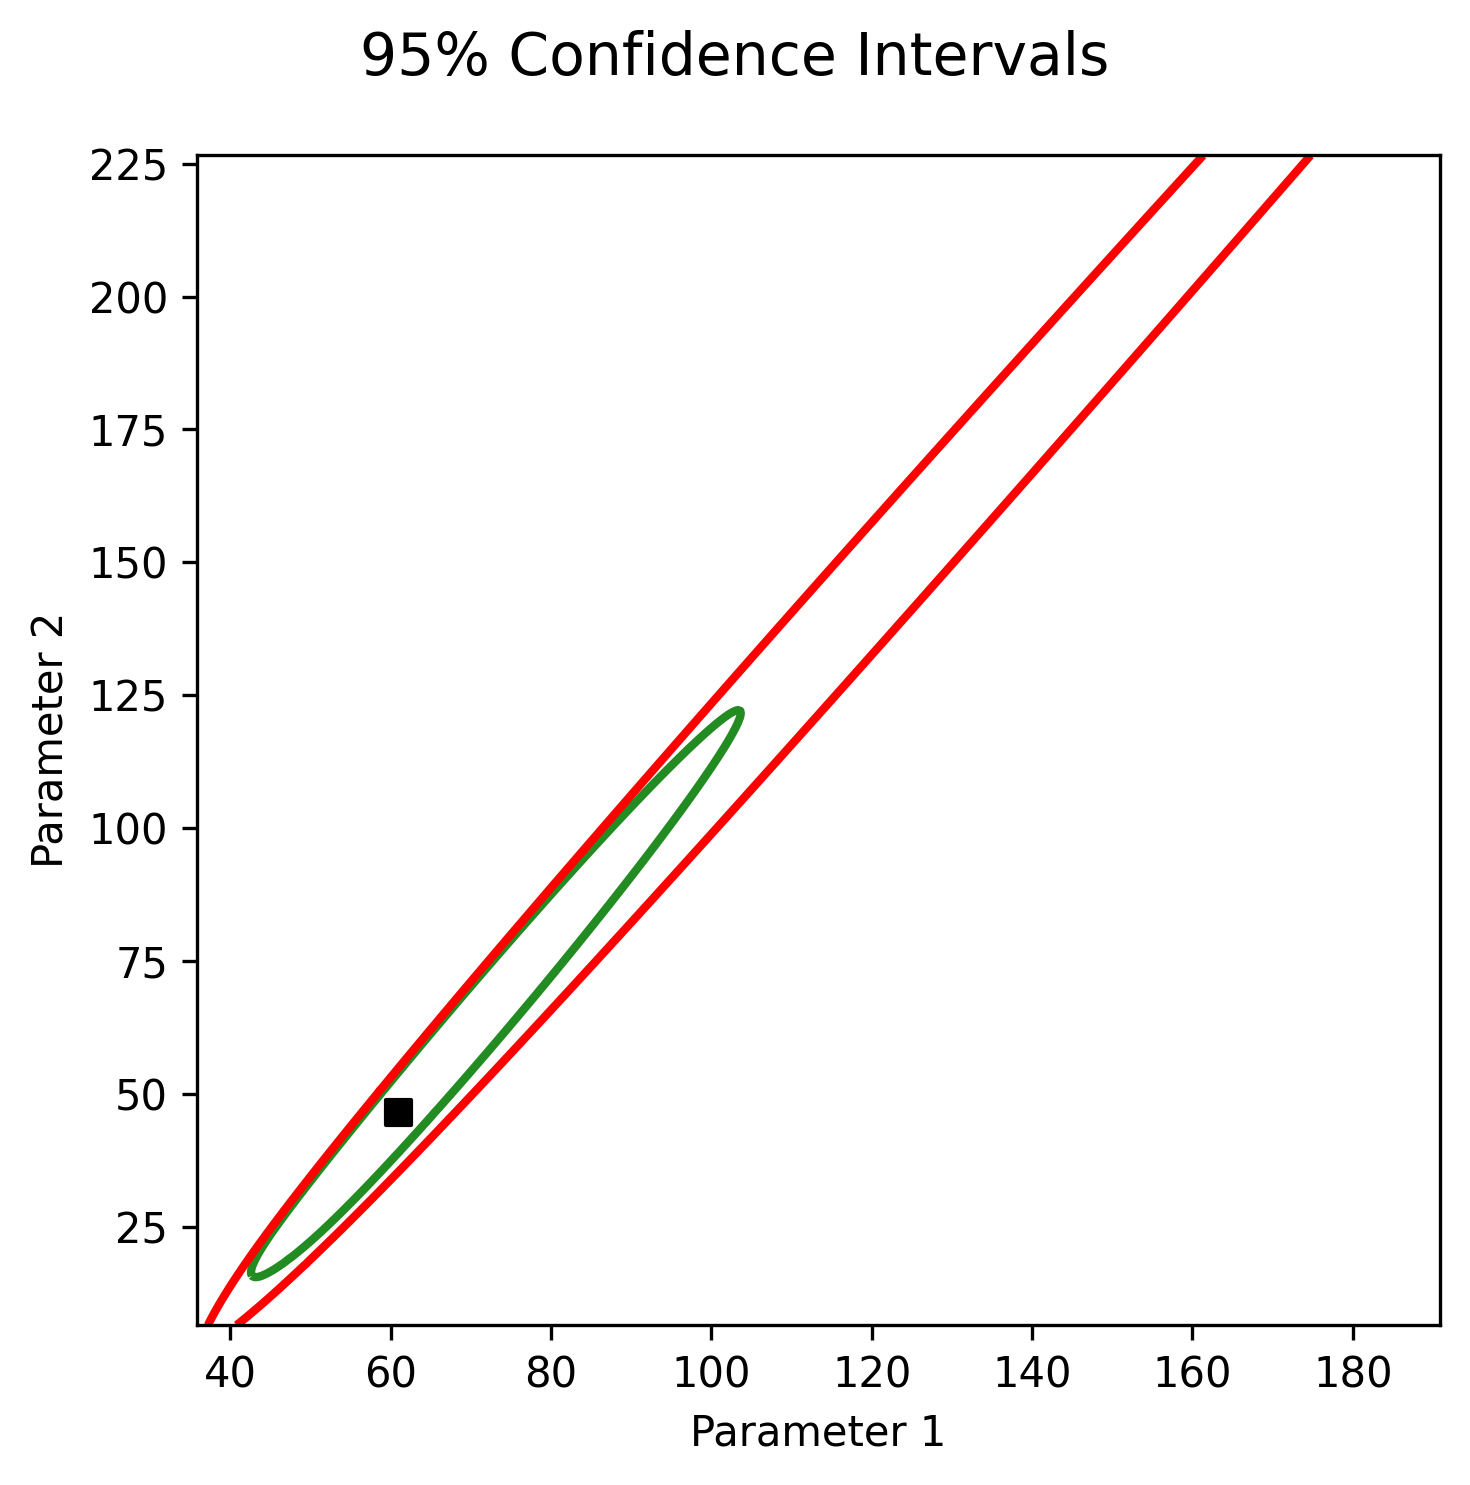

In [110]:
ed_params, n_params = split_likelihood_ed.compare_CI(split_likelihood, vector_field, delta_upper=[130, 180], delta_lower=[25, 40], num_points=500, plot=True)

In [117]:
def compare_trajectory_CI(self, other, field, CI_params_self, CI_params_other, times = jnp.linspace(0, 10, 1000), plot=False):
    
    self_min, self_max, self_mle = self.trajectory_CI(field, CI_params_self, times)
    other_min, other_max, other_mle = other.trajectory_CI(field, CI_params_other, times)
    
    if plot:
        # Plotting
        plt.fill_between(times, self_min.flatten(), self_max.flatten(), color = 'Blue', alpha = 0.3)
        plt.fill_between(times, self_min.flatten(), other_min.flatten(), color = 'Red', alpha = 0.3)
        plt.fill_between(times, self_max.flatten(), other_max.flatten(), color = 'Red', alpha = 0.3)
        plt.scatter(self.times, self.data, linewidths = 0.5)
        plt.plot(times, self_mle, color = 'Black', label='MLE trajectory')         
        
    return {
        'self': [self_min, self_max, self_mle],
        'other': [other_min, other_max, other_mle]
    }  
    
def compare_trajectory_CI(self, other, field, CI_params_self, CI_params_other, times = jnp.linspace(0, 10, 1000), mle=None, plot=False):
    
    self_min, self_max, self_mle = self.trajectory_CI(field, CI_params_self, times)
    other_min, other_max, other_mle = other.trajectory_CI(field, CI_params_other, times)

    mle = self.MLE if mle is None else solve(times, self.x0, mle, field)  

    if plot:
        # Determine the number of dimensions
        n_dims = self_min.shape[1]

        # Create subplots for each dimension
        fig, axs = plt.subplots(n_dims, 1, figsize=(10, 5 * n_dims))

        for dim in range(n_dims):
            ax = axs[dim] if n_dims > 1 else axs
            ax.fill_between(times, self_min[:, dim], self_max[:, dim], color='Blue', alpha=0.3)
            ax.fill_between(times, other_min[:, dim], other_max[:, dim], color='Red', alpha=0.3)
            ax.plot(times, self_mle[:, dim], color='Black', label=f'MLE trajectory (dim {dim})')
            ax.scatter(self.times, self.data[:, dim], linewidths=0.5)
            ax.legend()

        plt.tight_layout()
        
    return {
        'self': [self_min, self_max, self_mle],
        'other': [other_min, other_max, other_mle]
    }  

# def compare_trajectory_CI(self, other, field, CI_params_self, CI_params_other, times=jnp.linspace(0, 10, 1000), plot=False):
#     self_min, self_max, self_mle = self.trajectory_CI(field, CI_params_self, times)
#     other_min, other_max, other_mle = other.trajectory_CI(field, CI_params_other, times)

#     if plot:
#         # Plotting
#         plt.figure(figsize=(10, 6))

#         # Fill the regions unique to the self confidence interval
#         plt.fill_between(times, self_min, jnp.minimum(self_max, other_min), color='Blue', alpha=0.3)
#         plt.fill_between(times, jnp.maximum(self_min, other_max), self_max, color='Blue', alpha=0.3)

#         # Fill the regions unique to the other confidence interval
#         plt.fill_between(times, other_min, jnp.minimum(other_max, self_min), color='Red', alpha=0.3)
#         plt.fill_between(times, jnp.maximum(other_min, self_max), other_max, color='Red', alpha=0.3)

#         # Add scatter plot for data points
#         plt.scatter(self.times, self.data, linewidths=0.5)

#         # Plot MLE trajectory
#         plt.plot(times, self_mle, color='Black', label='MLE Trajectory')

#         # Add legend and labels
#         plt.legend()
#         plt.xlabel('Time')
#         plt.ylabel('Trajectory Value')

#         plt.show()

#     return {
#         'self': [self_min, self_max, self_mle],
#         'other': [other_min, other_max, other_mle]
#     }

    
def compare_trajectory_CI(self, other, field, CI_params_self, CI_params_other, times = jnp.linspace(0, 10, 1000), mle=None, plot=False, phase_space=False):
    self_min, self_max, self_mle = self.trajectory_CI(field, CI_params_self, times)
    other_min, other_max, other_mle = other.trajectory_CI(field, CI_params_other, times)

    # self_min, self_max, self_mle = self_mle_[0] - self_min_, self_mle_[0] - self_max_, self_mle_[0] - self_mle_ 
    # other_min, other_max, other_mle = other_mle_[0] - other_min_, other_mle_[0] - other_max_, other_mle_[0] - other_mle_
    
    mle = self.MLE if mle is None else solve(times, self.x0, mle, field)
    # design_points =  solve(self.times, self.x0, mle, field)
    if plot:
        if phase_space:
            # Determine the number of dimensions
            n_dims = self_min.shape[1]

            # Create subplots for each dimension
            # fig, axs = plt.subplots(n_dims, 1, figsize=(10, 5 * 2), dpi=300)
            fig, axs = plt.subplots(figsize=(10, 10), dpi=300)
            # Fill CI for 'self' with solid color
            # ax.fill_between(times, other_min[:, dim], other_max[:, dim], color='red', alpha=0.3, label='CI for Equidistant Design' if dim == 0 else None)
            axs.plot(other_min[:, 0], other_min[:, 1], linestyle='-', color='red')
            axs.plot(other_max[:, 0], other_max[:, 1], linestyle='-', color='red')
            # axs.fill_between( other_min[:, 0],other_max[:, 1], color='red', alpha=0.3, label='CI for Equidistant Design')
            # Outline CI for 'other' with a distinct color
            axs.plot(self_min[:, 0], self_min[:, 1], color='green', linestyle='-')
            axs.plot(self_max[:, 0], self_max[:, 1], color='green', linestyle='-', label='CI for Bayesian Experimental Design')
            # ax.fill_between(times, self_min[:, dim], self_max[:, dim], color='blue', alpha=0.3, label='CI for Bayesian Design' if dim == 0 else None)
            
            axs.plot(self_mle[:, 0], self_mle[:, 1], color='black', linewidth=2, label=f'MLE trajectory' )
            axs.scatter(self.data[:, 0], self.data[:, 1], s=10, linewidths=0.5, label = 'Bayesian ED Noisy Data', color = 'Black')
        
            return
        else:
            # Determine the number of dimensions
            n_dims = self_min.shape[1]

            # Create subplots for each dimension
            # fig, axs = plt.subplots(n_dims, 1, figsize=(10, 5 * 2), dpi=300)
            fig, axs = plt.subplots(figsize=(7, 5), dpi=300)
            for dim in range(n_dims):
                ax = axs[dim] if n_dims > 3 else axs
                # Fill CI for 'self' with solid color
                # ax.fill_between(times, other_min[:, dim], other_max[:, dim], color='red', alpha=0.3, label='CI for Equidistant Design' if dim == 0 else None)
                # times = jnp.log(times)
                ax.plot(times, other_min[:, dim], linestyle='-', color='red', label='CI for Equidistant Design' if dim == 0 else None)
                ax.plot(times, other_max[:, dim], linestyle='-', color='red')
                ax.fill_between(times, other_min[:, dim], other_max[:, dim], color='red', alpha=0.3)
                
                # Outline CI for 'other' with a distinct color
                ax.plot(times, self_min[:, dim], color='forestgreen', linestyle='-', alpha=1)
                ax.plot(times, self_max[:, dim], color='forestgreen', linestyle='-', alpha=1, label='CI for Bayesian Experimental Design' if dim == 0 else None)
                ax.fill_between(times, self_min[:, dim], self_max[:, dim], color='forestgreen', alpha=0.5)#, label='CI for Bayesian Design' if dim == 0 else None)
    
                ax.plot(times, self_mle[:, dim], color='black', linewidth=2, label=f'True trajectory' if dim == 0 else None)
                ax.scatter(self.times, self.data[:, dim], s=3, linewidths=0.5, label = 'Bayesian ED Noisy Data' if dim == 0 else None, color = 'Black')
                # ax.scatter(self.times, design_points[:, dim], s=20, linewidths=4, label = 'Bayesian ED Noisy Data' if dim == 0 else None, color = 'orange',
                #            marker='x')

        # Set axis labels
        fig.suptitle('95% Trajectory Confidence Interval', fontsize=14)
        ax.set_xlabel('Time')
        ax.set_ylabel('Trajectory Value')
        ax.legend(frameon=False)

        plt.tight_layout()

    return {
        'self': [self_min, self_max, self_mle],
        'other': [other_min, other_max, other_mle]
    }
    
# traj_dict = compare_trajectory_CI(split_likelihood_ed, split_likelihood, vector_field, ed_params, n_params, 
#                                                         times = jnp.linspace(0, 10, 1000),
#                                                         plot = True, phase_space = False)



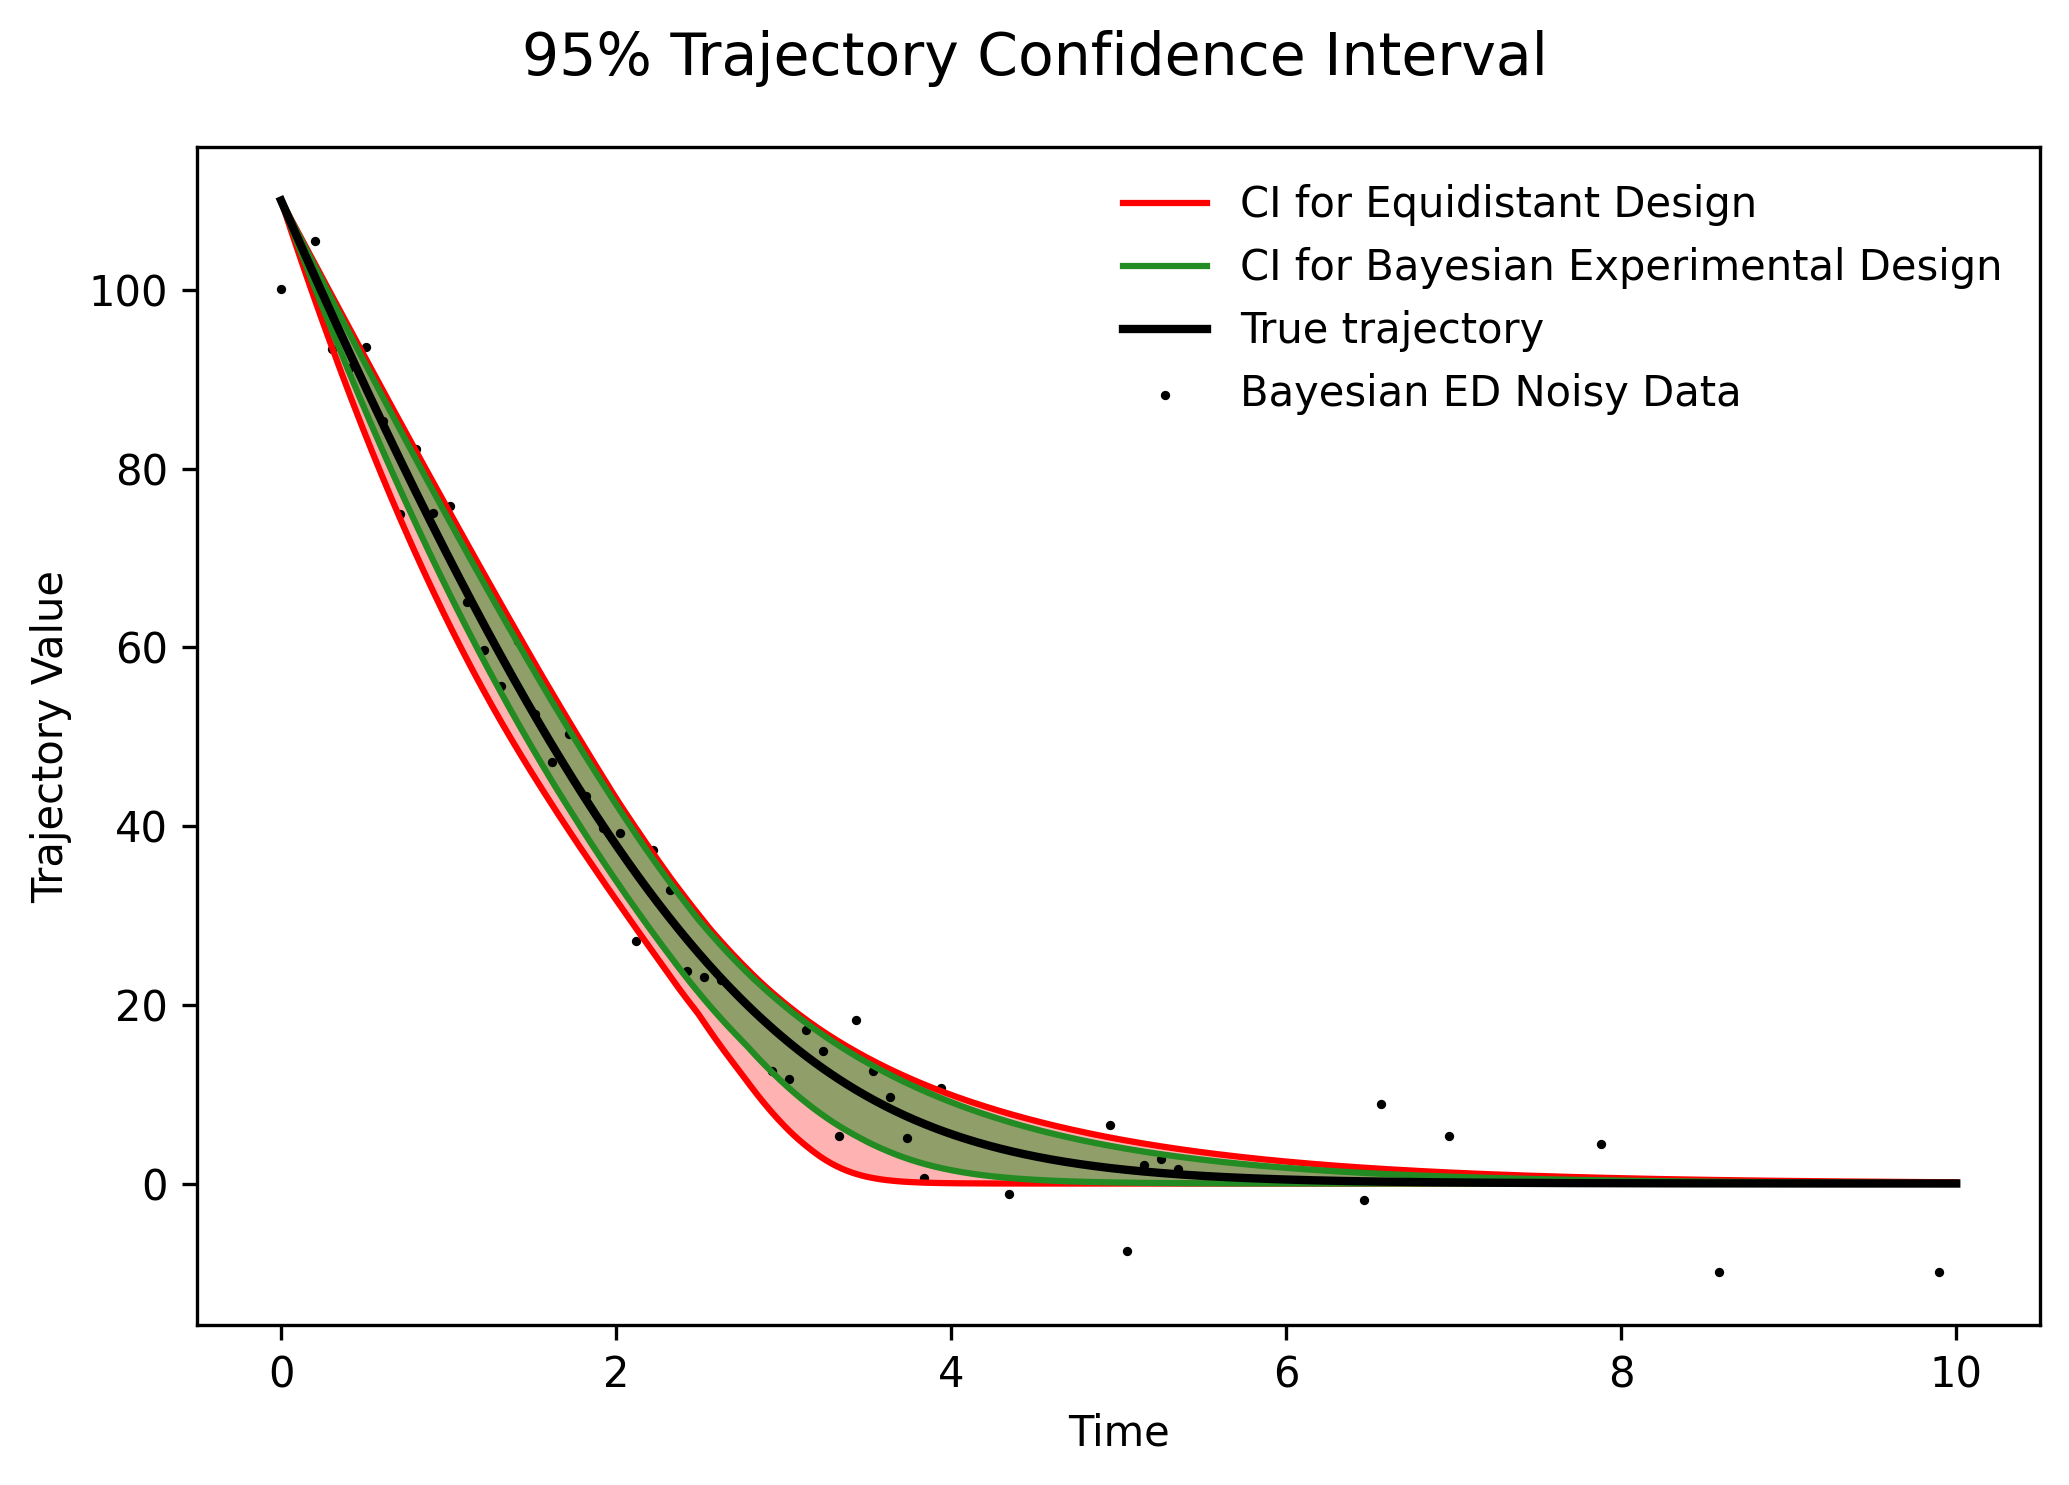

In [112]:
traj_dict = compare_trajectory_CI(split_likelihood_ed, split_likelihood, vector_field, ed_params, n_params, 
                                                        times = jnp.linspace(0, 10, 1000),
                                                        plot = True, phase_space = False)

### Lotka-Voltera

In [55]:
jax.config.update("jax_enable_x64", True)

t_range = [0, 10]
n_points = 100

true_args = jnp.array([1.6, 0.9, 0.5, 1.0])
true_x0 = jnp.array([1.0, 1.0])
noise_std_dev = 0.5
key = jax.random.PRNGKey(0)
vector_field = s2_vfield


w0 = jnp.array([1.0, 1.0, 1.0, 1.0])
folds = 2

ed = None

ed = jnp.array([0, 13, 99, 32, 51, 69, 84, 41, 23,  7])

ed = jnp.array([ 0, 13, 98, 32, 51, 69, 84, 41, 23,  7])# 59, 91, 76,  1,  6, 97, 44])
       # 24,  8, 62, 34, 92, 52,  5, 77,  2, 22, 66, 90, 35,  9, 45, 57, 82,
       #  4, 28, 93, 96, 70, 21, 36, 47, 60, 10,  3, 83, 71, 25, 33, 49])

# ed = jnp.array([ 0, 99, 70, 31, 51, 17, 83,  0, 99, 37, 61,  0,  5, 17, 80,  0, 99,
#        47,  0,  4, 16, 64,  0, 99, 80,  4,  0, 32, 14, 95, 99,  4,  0, 83,
#        48,  0, 13,  4, 99, 64,  0,  4, 13, 95,  0, 99, 84, 30,  4, 12])


t_ed, data_ed, noisy_data_ed = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed)
t, data, noisy_data = generate_synthetic_data(t_range, 10, true_args, true_x0, noise_std_dev, key, vector_field, None)

split_likelihood_ed = SplitLikelihood(key, noisy_data_ed, t_ed, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood_ed.fit(vector_field, w0=w0, max_iter=15000, lr=0.01, optimizer_type='adam')
# ci_ranges_ed = split_likelihood_ed.get_full_CI(vector_field, delta_upper=[50, 50], delta_lower=[25, 25], num_points=500, plot_grid=True)
# plot_CI_points(*ci_ranges_ed)

split_likelihood= SplitLikelihood(key, noisy_data, t, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood.fit(vector_field, w0=w0, max_iter=15000, lr=0.01, optimizer_type='adam')

ic| results: diffrax._solution.RESULTS<traced>
ic| results: diffrax._solution.RESULTS<traced>
ic| results: diffrax._solution.RESULTS<traced>


Time elapsed:  8.093453168869019


ic| results: diffrax._solution.RESULTS<>
ic| results: diffrax._solution.RESULTS<>
ic| results: diffrax._solution.RESULTS<traced>
ic| self.MLE: Array([1.47879229, 0.75829683, 0.53067602, 1.05272759], dtype=float64)


Time elapsed:  3.2542479038238525


ic| results: diffrax._solution.RESULTS<traced>
ic| results: diffrax._solution.RESULTS<traced>
ic| results: diffrax._solution.RESULTS<traced>
ic| results: diffrax._solution.RESULTS<>
ic| results: diffrax._solution.RESULTS<>
ic| results: diffrax._solution.RESULTS<traced>


Time elapsed:  3.828463077545166


ic| self.MLE: Array([1.647098  , 0.83280085, 0.50092282, 1.0001557 ], dtype=float64)


Time elapsed:  1.549834966659546


In [109]:
ed_params, n_params = split_likelihood_ed.compare_CI(split_likelihood, vector_field, delta_upper=[1.7, 1.2, 0.7, 1.2],
                                                     delta_lower=[1.2, 0.4, 0.4, 0.4], num_points=25, plot = False, mle = true_args)

ic| slr_values_self.shape: (25, 25, 25, 25)
    slr_values_other.shape: (25, 25, 25, 25)


# S1

In [118]:
#---Step 1: Generate synthetic training data---------------------
ti = jnp.linspace(0, 10, 10)
t_ = jnp.linspace(0, 10, 100)
args = jnp.array((-2, -5.0))# Assuming these are the true parameters for kcat and K_m
# multi_args = jnp.array([(60.0, 30.4), (30, 70), (25, 45), (100, 10)])
multi_args = jax.random.uniform(key = jax.random.PRNGKey(0), shape = (100, 2), minval = jnp.array([-5.0, -5.0]), maxval=jnp.array([-0.1, -0.1]))
true_x0 = jnp.array([2, 2.0]) # True initial condition
synthetic_data = solve(ti, true_x0, args, s1_vfield) # Generating synthetic data
synthetic_data = synthetic_data + jax.random.normal(jax.random.PRNGKey(0), shape=synthetic_data.shape) * 1
# Floor the data to zero
synthetic_data = jnp.where(synthetic_data < 0, 0, synthetic_data)
#----------------------------------------------------------------


#---Step 2: Load the model---------------------------------------  
jax.config.update("jax_enable_x64", False)
model = load('/Users/antanas/GitRepo/NODE/Models/S1_0118/S1_3D.eqx', type='DynamicKoopman')    # model = load("/Users/antanas/GitRepo/NODE/Models/PLearnKoopman_MM_2D_Cons_K", type = 'PlearnKoopmanCL')
jax.config.update("jax_enable_x64", True)

In [119]:
jax.config.update("jax_enable_x64", True)

t_range = [0, 10]
n_points = 100

true_args = jnp.array((-0.3, -2.0))
true_x0 = jnp.array([5.0, 0.0]) # True initial condition
noise_std_dev = 2
key = jax.random.PRNGKey(0)
vector_field = s1_vfield

folds = 3

ed = None

# ed = jnp.array([ 1,  2,  3,  8, 38, 16,  4, 14,  5, 19,  1,  6, 27, 10,  3, 62,  1,
                # 34, 21, 32,  3,  6,  1, 87,  3,  9,  1, 13,  6,  3])#, 42, 18,  1,  9,
                #  6,  0,  3,  1,  5,  3, 13,  9,  1,  3,  5,  3,  0,  5,  1,  3])  sigma = 0.1 lam = 0.001 prior = 1 ??
                
ed = jnp.array([ 1,  3, 32,  8, 57,  1, 16,  5, 19,  0])#,  1, 82,  5, 26,  1,  0,  9,
                 #1, 35,  4,  0,  1, 99,  1, 14,  4,  0,  1,  9,  0]) # sigma = 0.1 lam = 0.001 prior = 1

ed = jnp.array([ 1,  3, 32,  8, 57,  1, 15,  4, 19,  1, 82,  1,  4,  1, 25,  1,  4,
                 9, 35])#,  1, 99,  0,  1,  4,  1,  0,  1,  4, 14,  9]) # sigma = 0.1 lam = 0.001 prior = 5

ed = jnp.array([1,  2,  3,  5, 13, 24,  4, 15,  6, 19,  8, 21,  1, 94, 63, 88,  5,
                 53, 51,  3, 10,  2, 34,  1, 82, 16, 27, 32, 32, 33]) # sigma = 0.0001 lam = 0.1 prior =

ed = jnp.array([25, 51, 74,  1,  2,  3,  5, 16, 99,  4, 15,  6, 18,  7, 23,  1, 16,
                 3,  5, 13,  8, 35,  9, 41,  1, 20,  3, 94, 35, 18]) # Cartesian design


t_ed, data_ed, noisy_data_ed = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed,  noise_percentage = None)
t, data, noisy_data = generate_synthetic_data(t_range, 30, true_args, true_x0, noise_std_dev, key, vector_field, None,  noise_percentage = None)

split_likelihood_ed = SplitLikelihood(key, noisy_data_ed, t_ed, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood_ed.fit(vector_field, w0=jnp.array([-1.0, -1.0]), max_iter=10000, lr=0.001, optimizer_type='adam')
# ci_ranges_ed = split_likelihood_ed.get_full_CI(vector_field, delta_upper=[50, 50], delta_lower=[25, 25], num_points=500, plot_grid=True)
# plot_CI_points(*ci_ranges_ed)

split_likelihood= SplitLikelihood(key, noisy_data, t, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood.fit(vector_field, w0=jnp.array([-1.0, -1.0]), max_iter=10000, lr=0.001, optimizer_type='adam')

Time elapsed:  11.208490133285522


ic| self.MLE: Array([-0.29579998, -1.95297295], dtype=float64)


Time elapsed:  3.4511559009552
Time elapsed:  3.911118745803833


ic| self.MLE: Array([-0.30423778, -2.05113851], dtype=float64)


Time elapsed:  1.6266441345214844


(2,)


ic| slr_values_self.shape: (500, 500)
    slr_values_other.shape: (500, 500)


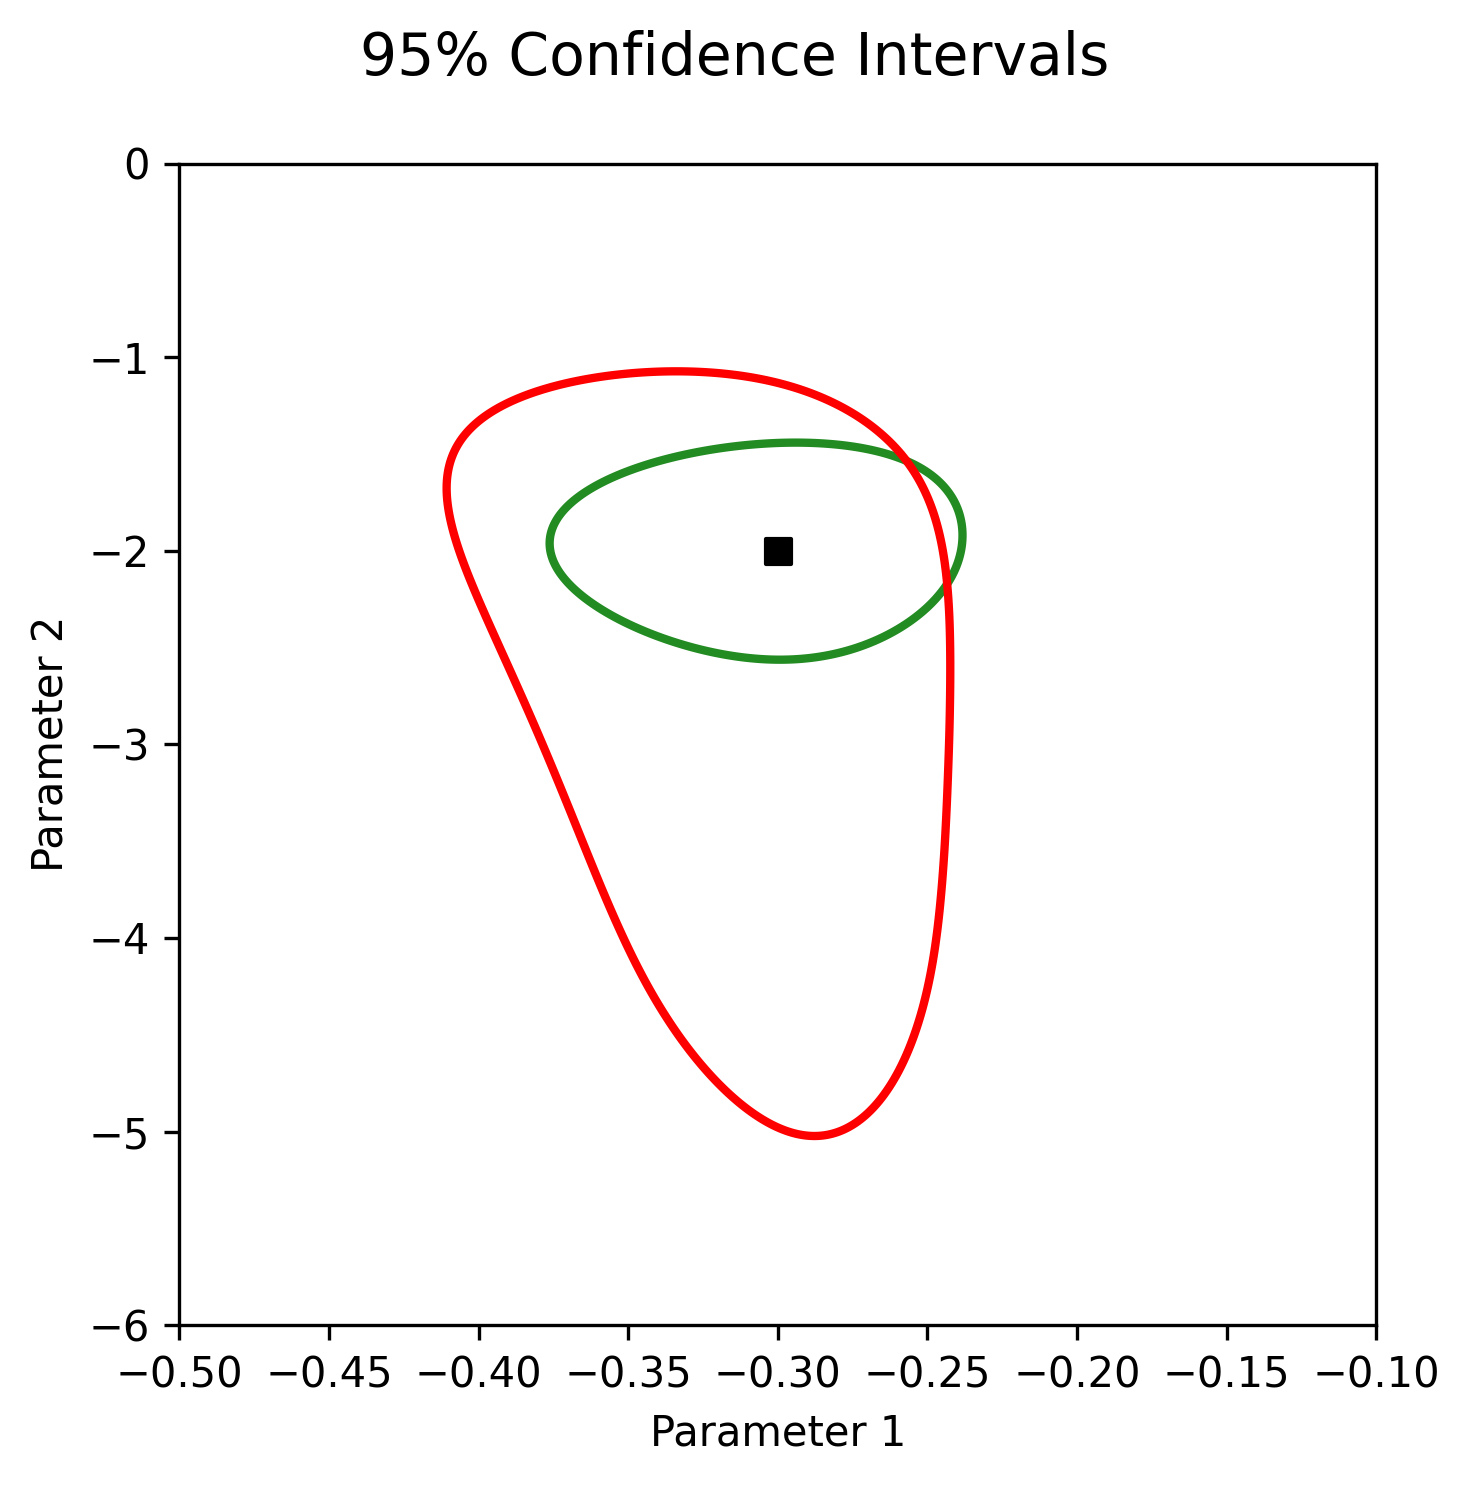

In [120]:
ed_params, n_params = split_likelihood_ed.compare_CI(split_likelihood, vector_field, delta_upper=[0.2, 2.0],
                                                     delta_lower=[0.2, 4.0], num_points=500, plot = True, mle = true_args)

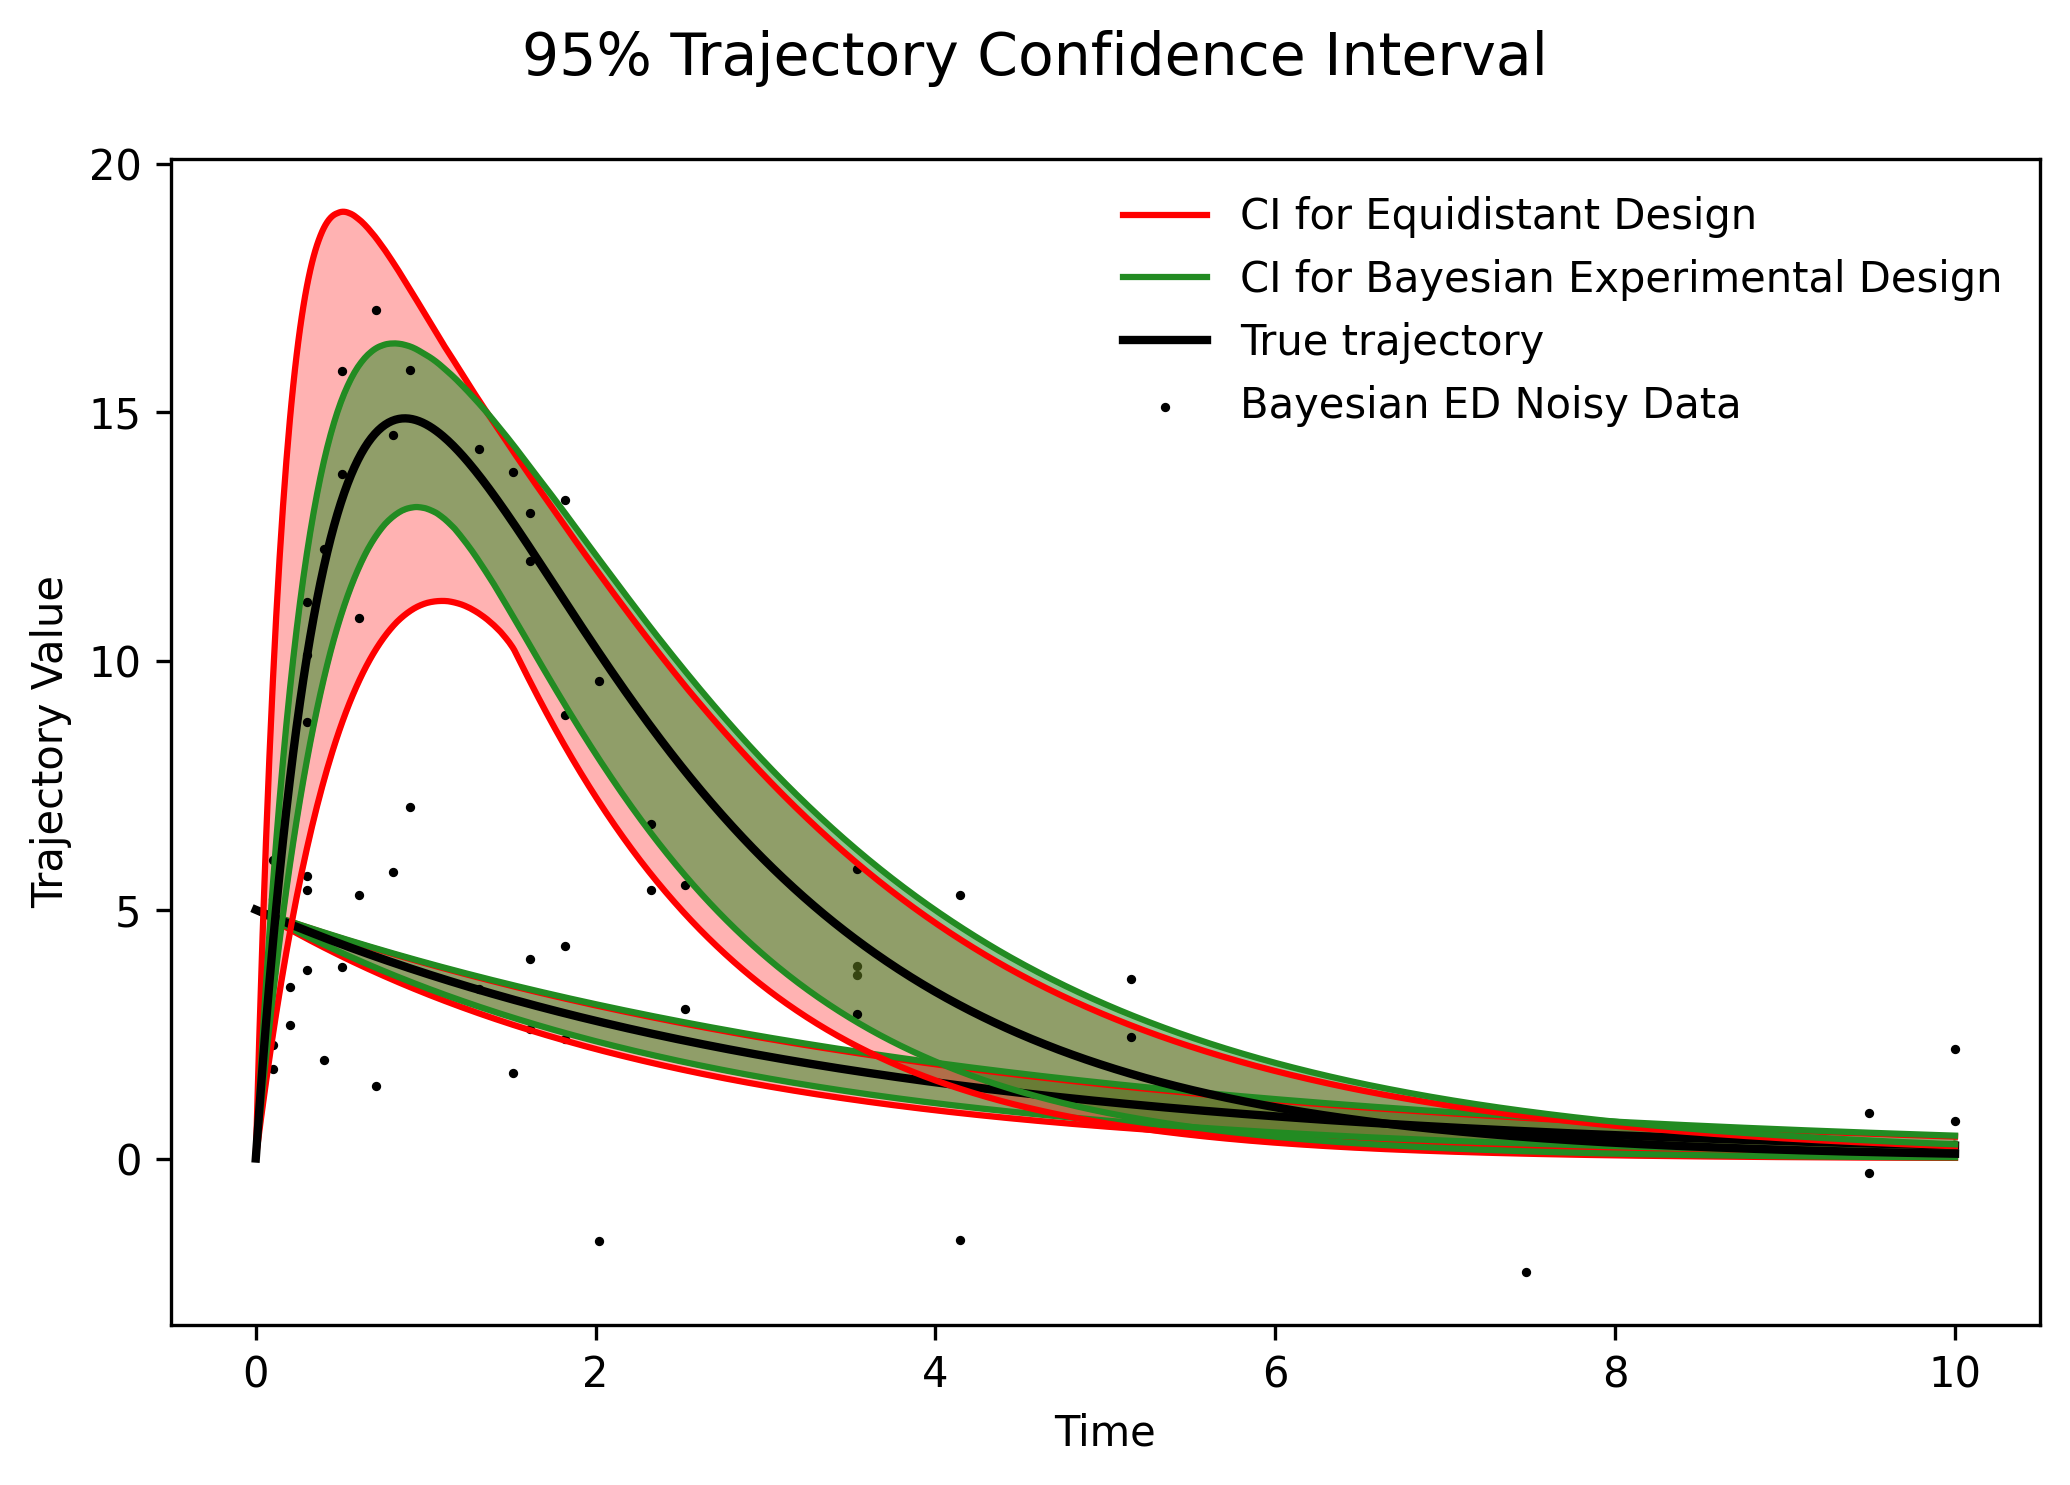

In [121]:
traj_dict = compare_trajectory_CI(split_likelihood_ed, split_likelihood, vector_field, ed_params, n_params, 
                                                        times = jnp.linspace(0, 10, 1000),
                                                        plot = True)


# PK

In [7]:
#---Step 1: Generate synthetic training data---------------------
ti = jnp.linspace(0, 10, 10)
t_ = jnp.linspace(0, 10, 100)
args = jnp.array((2.0, 5.0, 0.1))# Assuming these are the true parameters for kcat and K_m
# multi_args = jnp.array([(60.0, 30.4), (30, 70), (25, 45), (100, 10)])
# multi_args = jax.random.uniform(key = jax.random.PRNGKey(0), shape = (100, 2), minval = jnp.array([-5.0, -5.0]), maxval=jnp.array([-0.1, -0.1]))
true_x0 = jnp.array([20.0, 0.0]) # True initial condition
synthetic_data = solve(ti, true_x0, args, s7_vfield) # Generating synthetic data
synthetic_data = synthetic_data + jax.random.normal(jax.random.PRNGKey(0), shape=synthetic_data.shape) * 1
# Floor the data to zero
synthetic_data = jnp.where(synthetic_data < 0, 0, synthetic_data)
#----------------------------------------------------------------


#---Step 2: Load the model---------------------------------------  
jax.config.update("jax_enable_x64", False)
model = load("/Users/antanas/GitRepo/NODE/Models/PK/PK_D3_0213.eqx", type = 'DynamicKoopman')
jax.config.update("jax_enable_x64", True)

In [61]:
jax.config.update("jax_enable_x64", True)

t_range = [0, 10]
n_points = 100

true_args = jnp.array((2.0, 20.0, 60.0))# Assuming these are the true parameters for kcat and K_m
# true_args = jnp.array((-2, -5.0))# Assuming these are the true parameters for kcat and K_m
# true_args = jnp.array((-0.5, -4.1))# Assuming these are the true parameters for kcat and K_m
true_x0 = jnp.array([20.0, 0.0]) # True initial condition
noise_std_dev = 2
key = jax.random.PRNGKey(0)
vector_field = s7_vfield

folds = 5

ed = None

# ed = jnp.array([ 1,  2,  3,  8, 38, 16,  4, 14,  5, 19,  1,  6, 27, 10,  3, 62,  1,
                # 34, 21, 32,  3,  6,  1, 87,  3,  9,  1, 13,  6,  3])#, 42, 18,  1,  9,
                #  6,  0,  3,  1,  5,  3, 13,  9,  1,  3,  5,  3,  0,  5,  1,  3])  sigma = 0.1 lam = 0.001 prior = 1 ??
                
# ed = jnp.array([ 1,  3, 32,  8, 57,  1, 16,  5, 19,  0])#,  1, 82,  5, 26,  1,  0,  9,
#                  #1, 35,  4,  0,  1, 99,  1, 14,  4,  0,  1,  9,  0]) # sigma = 0.1 lam = 0.001 prior = 1

# ed = jnp.array([ 1,  3, 32,  8, 57,  1, 15,  4, 19,  1, 82,  1,  4,  1, 25,  1,  4,
#                  9, 35])#,  1, 99,  0,  1,  4,  1,  0,  1,  4, 14,  9]) # sigma = 0.1 lam = 0.001 prior = 5

# ed = jnp.array([1,  2,  3,  5, 13, 24,  4, 15,  6, 19,  8, 21,  1, 94, 63, 88,  5,
#                  53, 51,  3, 10,  2, 34,  1, 82, 16, 27, 32, 32, 33]) # sigma = 0.0001 lam = 0.1 prior =

ed = jnp.array([21,  1,  2, 10,  3, 12, 40,  1, 23,  4,  1,  8,  1, 27,  4,  1, 57,
                 1,  8,  4,  1, 18, 13, 34,  4,  1,  8,  1,  4,  1]) 

ed = jnp.array([21,  1,  2, 10,  3, 12, 40,  4, 20,  9,  5, 59,  8, 32, 13, 18,  6,
                14, 36, 23, 43, 15, 78, 19, 24, 29, 11, 52, 25, 16])#,  1, 82,  5, 26,  1,  0,  9,

ed = jnp.array([ 1,  2, 29,  8,  3, 11,  4, 19, 49,  5,  9, 25, 13, 32, 14, 68,  6,
                10, 41, 15, 18, 24, 20, 88, 50, 35, 45, 30, 16, 54])

ed = jnp.array([24,  1,  6, 45,  2, 12, 68, 92, 20,  7,  3, 31,  8, 13, 51, 19,  5,
                14, 18,  4, 79, 99, 97, 11,  9, 25, 39, 26, 58, 32, 15, 17, 21, 38,
                27, 30, 84, 33, 44, 37, 23, 96, 22, 34, 28, 43, 64, 40, 50, 46])




t_ed, data_ed, noisy_data_ed = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed,  noise_percentage = None)
t, data, noisy_data = generate_synthetic_data(t_range, len(ed), true_args, true_x0, noise_std_dev, key, vector_field, None,  noise_percentage = None)

split_likelihood_ed = SplitLikelihood(key, noisy_data_ed, t_ed, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood_ed.fit(vector_field, w0=jnp.array([3.0, 30.0, 50.0]), max_iter=10000, lr=0.001, optimizer_type='adam')
# ci_ranges_ed = split_likelihood_ed.get_full_CI(vector_field, delta_upper=[50, 50], delta_lower=[25, 25], num_points=500, plot_grid=True)
# plot_CI_points(*ci_ranges_ed)

split_likelihood= SplitLikelihood(key, noisy_data, t, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood.fit(vector_field, w0=jnp.array([3.0, 30.0, 50.0]), max_iter=10000, lr=0.001, optimizer_type='adam')

Time elapsed:  5.293190956115723


ic| self.MLE: Array([ 2.11374552, 21.11103039, 58.43438736], dtype=float64)


Time elapsed:  1.8159496784210205
Time elapsed:  4.609156131744385


ic| self.MLE: Array([ 2.3330399 , 20.82948475, 58.70300044], dtype=float64)


Time elapsed:  1.9613299369812012


In [62]:
ed_params, n_params = split_likelihood_ed.compare_CI(split_likelihood, vector_field, delta_upper=[3.0, 80.0, 200.0],
                                                     delta_lower=[1.0, 10.0, 50.0], num_points=100, plot = False, mle = true_args)

(3,)


ic| slr_values_self.shape: (100, 100, 100)
    slr_values_other.shape: (100, 100, 100)


In [63]:
jnp.max(ed_params, axis = 0)

Array([  2.81818182,  90.        , 260.        ], dtype=float64)

In [68]:
ed_params.shape

(37653, 3)

In [69]:
n_params.shape

(50698, 3)

In [70]:
jnp.max(n_params, axis = 0)

Array([  3.54545455,  90.        , 260.        ], dtype=float64)

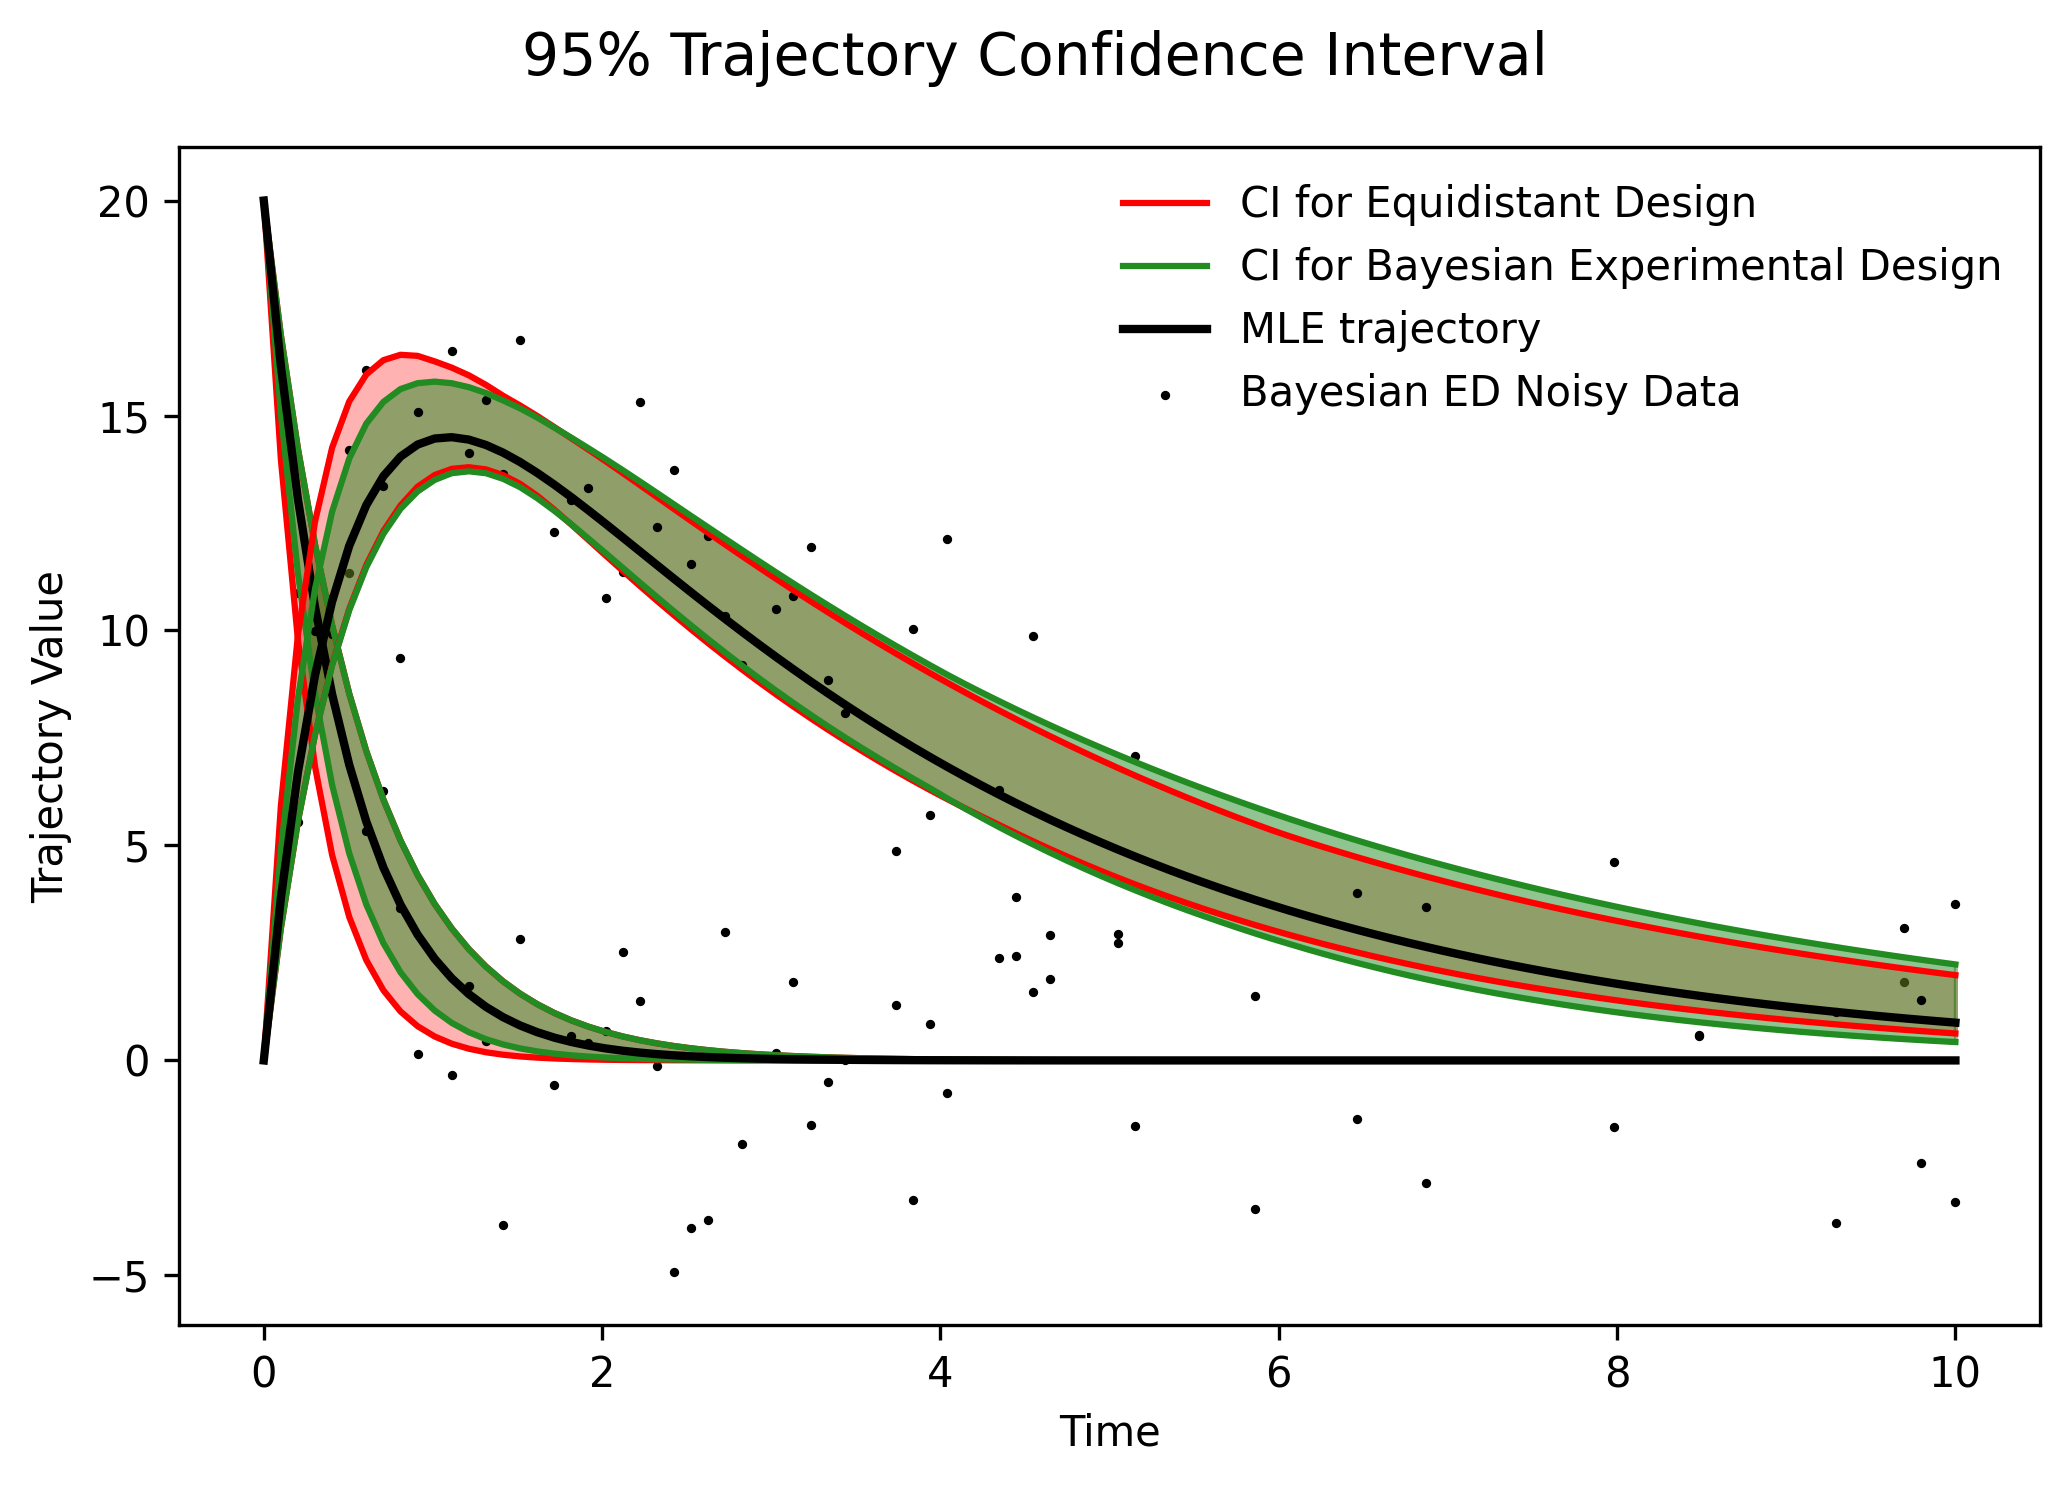

In [71]:
traj_dict = compare_trajectory_CI(split_likelihood_ed, split_likelihood, vector_field, ed_params, n_params, 
                                                        times = jnp.linspace(0, 10, 100),
                                                        plot = True)


### Van Der Pol

In [80]:
jax.config.update("jax_enable_x64", True)

t_range = [0, 10]
n_points = 100

true_args = jnp.array([1.5]) # Assuming these are the true parameters for kcat and K_m
# true_args = jnp.array((-2, -5.0))# Assuming these are the true parameters for kcat and K_m

true_x0 = jnp.array([0.2, 2.0]) # True initial condition
# true_x0 = jnp.array([0.5, 1.0])
noise_std_dev = 0.5
key = jax.random.PRNGKey(1)
vector_field = s5_vfield

folds = 2
ed = None



ed = jnp.array([ 34, 69, 99, 51, 15, 88,  1,  9, 98, 91])#, 56, 43, 97,  2,  6,  0,
                # 99, 93, 97, 42])#, 18,  1,  9,
                #  6,  0,  3,  1,  5,  3, 13,  9,  1,  3,  5,  3,  0,  5,  1,  3])

# ed = jnp.array([ 0, 22,  0,  5,  0, 43,  4, 15,  0,  4,  0,  4,  0, 13,  4,  0,  3,
#                  0,  3,  0, 12,  3,  0, 31,  3,  0,  3, 11,  0,  3,  0,  3, 62, 11,
#                  0,  3,  0,  3,  0,  3, 11,  3,  0,  3,  0, 10,  3,  0,  3,  0])

# ed = [31, 67, 98, 48, 86, 12, 99, 97, 61, 34]

# ed = jnp.array([25, 72, 99, 49, 98,  1, 36, 81,  2,  5])#, 58, 97, 94, 11,  3, 16,  1,
                # 85, 96, 77])
                
ed = jnp.array([25, 72, 99, 49, 87, 11, 37, 61, 99,  6, 85, 22, 35, 93, 73, 58, 99,
                47,  6, 16])

ed = jnp.array([30, 67, 99, 48, 83, 15, 59, 38, 99, 88, 73, 13, 27, 54, 41, 99,  9,
                89, 70, 26]) # sigma 2

ed = jnp.array([30, 67, 99, 48, 84, 14, 58, 39, 73, 91, 99, 12, 26, 58,  7, 99, 41,
                89, 73, 27]) # sigma 1.5

# ed = jnp.array([26, 74, 50, 99, 12, 88, 38, 62,  5, 99, 22, 92, 76, 37, 63, 50,  5,
#                 99, 84, 94])
ed = jnp.array([26, 74, 50, 99, 12, 88, 38, 62,  5, 99, 22, 92, 76, 37, 63, 50,  5,
                99, 84, 94])#, 15, 99, 27,  4, 72, 41, 56, 94, 99,  4]) # sigma = 1 30 total points

# ed = jnp.array([26, 74, 50, 99, 12, 88, 38, 62,  5, 99, 22, 92, 76, 37, 63, 50,  5,
#                 99, 84, 94, 15, 99, 27,  4, 72, 41, 56, 94, 99,  4, 94, 99, 83, 25,
#                  4, 14, 73, 48, 99, 95, 61,  4, 37, 99, 95, 23, 76, 99, 95,  4]) # sigma = 1 50 total points    

# ed = jnp.array([26, 74, 50, 99, 87, 14, 38, 62, 99, 83, 15, 35, 65, 50, 99, 27, 10,
#                 73, 89, 43, 58, 99, 28,  8, 72, 88, 42, 58, 99, 18]) # sigma = 2

# ed = jnp.array([26, 74, 50, 99, 86, 38, 62, 16, 99, 82, 37, 16, 62, 49, 99, 71, 29,
#                 87, 13, 52, 99, 36, 68, 14, 85, 27, 99, 48, 62, 75]) # sigma = 3   30 points

# ed = jnp.array([26, 74, 50, 99, 86, 38, 62, 16, 99, 82, 37, 16, 62, 49, 99, 71, 29,
#                 87, 13, 52, 99, 36, 68, 14, 85, 27, 99, 48, 62, 75, 12, 88, 39, 99,
#                 27, 57, 71, 11, 44, 99, 87, 28, 59, 10, 99, 73, 42, 89, 26, 56]) # sigma = 3 50 points


ed = jnp.array([28, 79, 52, 99, 12, 64, 40, 91, 72,  5]) # Minimax / 10 points / sigma =1

ed2 = jnp.array([28, 79, 52, 99, 12, 64, 40, 91, 72,  5, 23, 99, 38, 86,  5, 53, 17, 93, 99, 68]) # Minimax / 20 points / sigma = 1

ed = jnp.array([28, 79, 52, 99, 12, 64, 40, 91, 72,  5, 23, 99, 38, 86,  5, 53, 17,
                93, 99, 68]) #, 27,  4, 79, 42, 94, 99,  4, 58, 26, 73, 99, 94,  4, 14,
                # 84, 42, 99, 95,  4, 26, 55, 99, 95, 75,  4, 64, 38, 99, 95, 22]) # Minimax / 50 points / sigma = 1 


# ed = jnp.array([98, 36, 93, 72, 20, 90, 69, 74, 20, 99, 92, 20, 91, 99, 94, 20, 69,
#                 89, 96, 20]) # Non-linear design / 20 points / sigma = 1

# ed = jnp.array([27, 22, 24,  7, 53, 94, 31, 93, 50, 14]) # Non-linear One sigma =1


t_ed, data_ed, noisy_data_ed = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed,  noise_percentage = None)

# t, data, noisy_data = generate_synthetic_data(t_range, n_points, true_args, true_x0, noise_std_dev, key, vector_field, ed2,  noise_percentage = None)

t, data, noisy_data = generate_synthetic_data(t_range, 100, true_args, true_x0, noise_std_dev, key, vector_field, None,  noise_percentage = None)

split_likelihood_ed = SplitLikelihood(key, noisy_data_ed, t_ed, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood_ed.fit(vector_field, w0=jnp.array([1.4]), max_iter=10000, lr=0.001, optimizer_type='adam')
# ci_ranges_ed = split_likelihood_ed.get_full_CI(vector_field, delta_upper=[50, 50], delta_lower=[25, 25], num_points=500, plot_grid=True)
# plot_CI_points(*ci_ranges_ed)

split_likelihood= SplitLikelihood(key, noisy_data, t, x0=true_x0, std_dev=noise_std_dev, K_folds=folds)
split_likelihood.fit(vector_field, w0=jnp.array([1.4]), max_iter=10000, lr=0.001, optimizer_type='adam')

Time elapsed:  5.301325082778931


ic| self.MLE: Array([1.62378581], dtype=float64)


Time elapsed:  1.5117108821868896
Time elapsed:  4.756328344345093


ic| self.MLE: Array([1.43530708], dtype=float64)


Time elapsed:  1.3536827564239502


(1,)


ic| slr_values_self.shape: (1000,), slr_values_other.shape: (1000,)


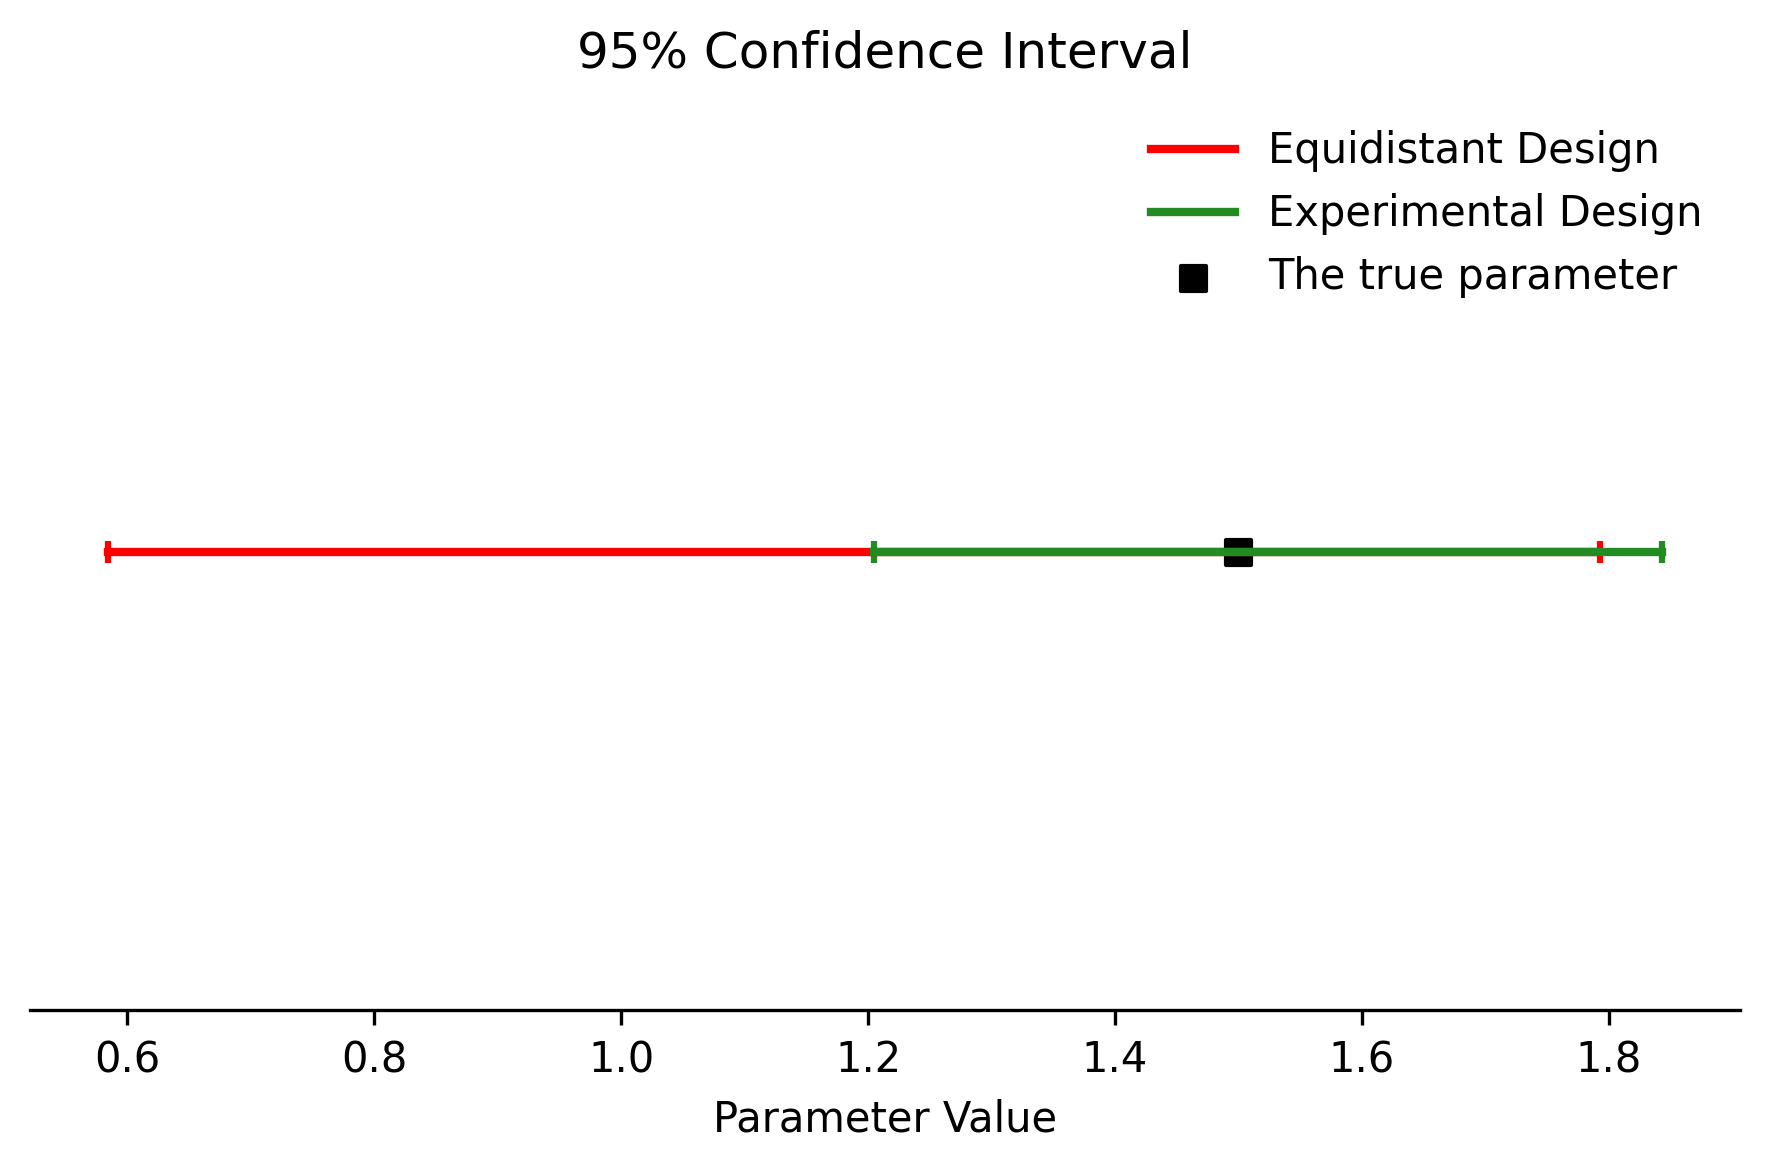

In [429]:
ed_params, n_params = split_likelihood_ed.compare_CI(split_likelihood, vector_field, delta_upper=[1.0],
                                                     delta_lower=[1.0], num_points=1000, plot = True, mle = true_args)

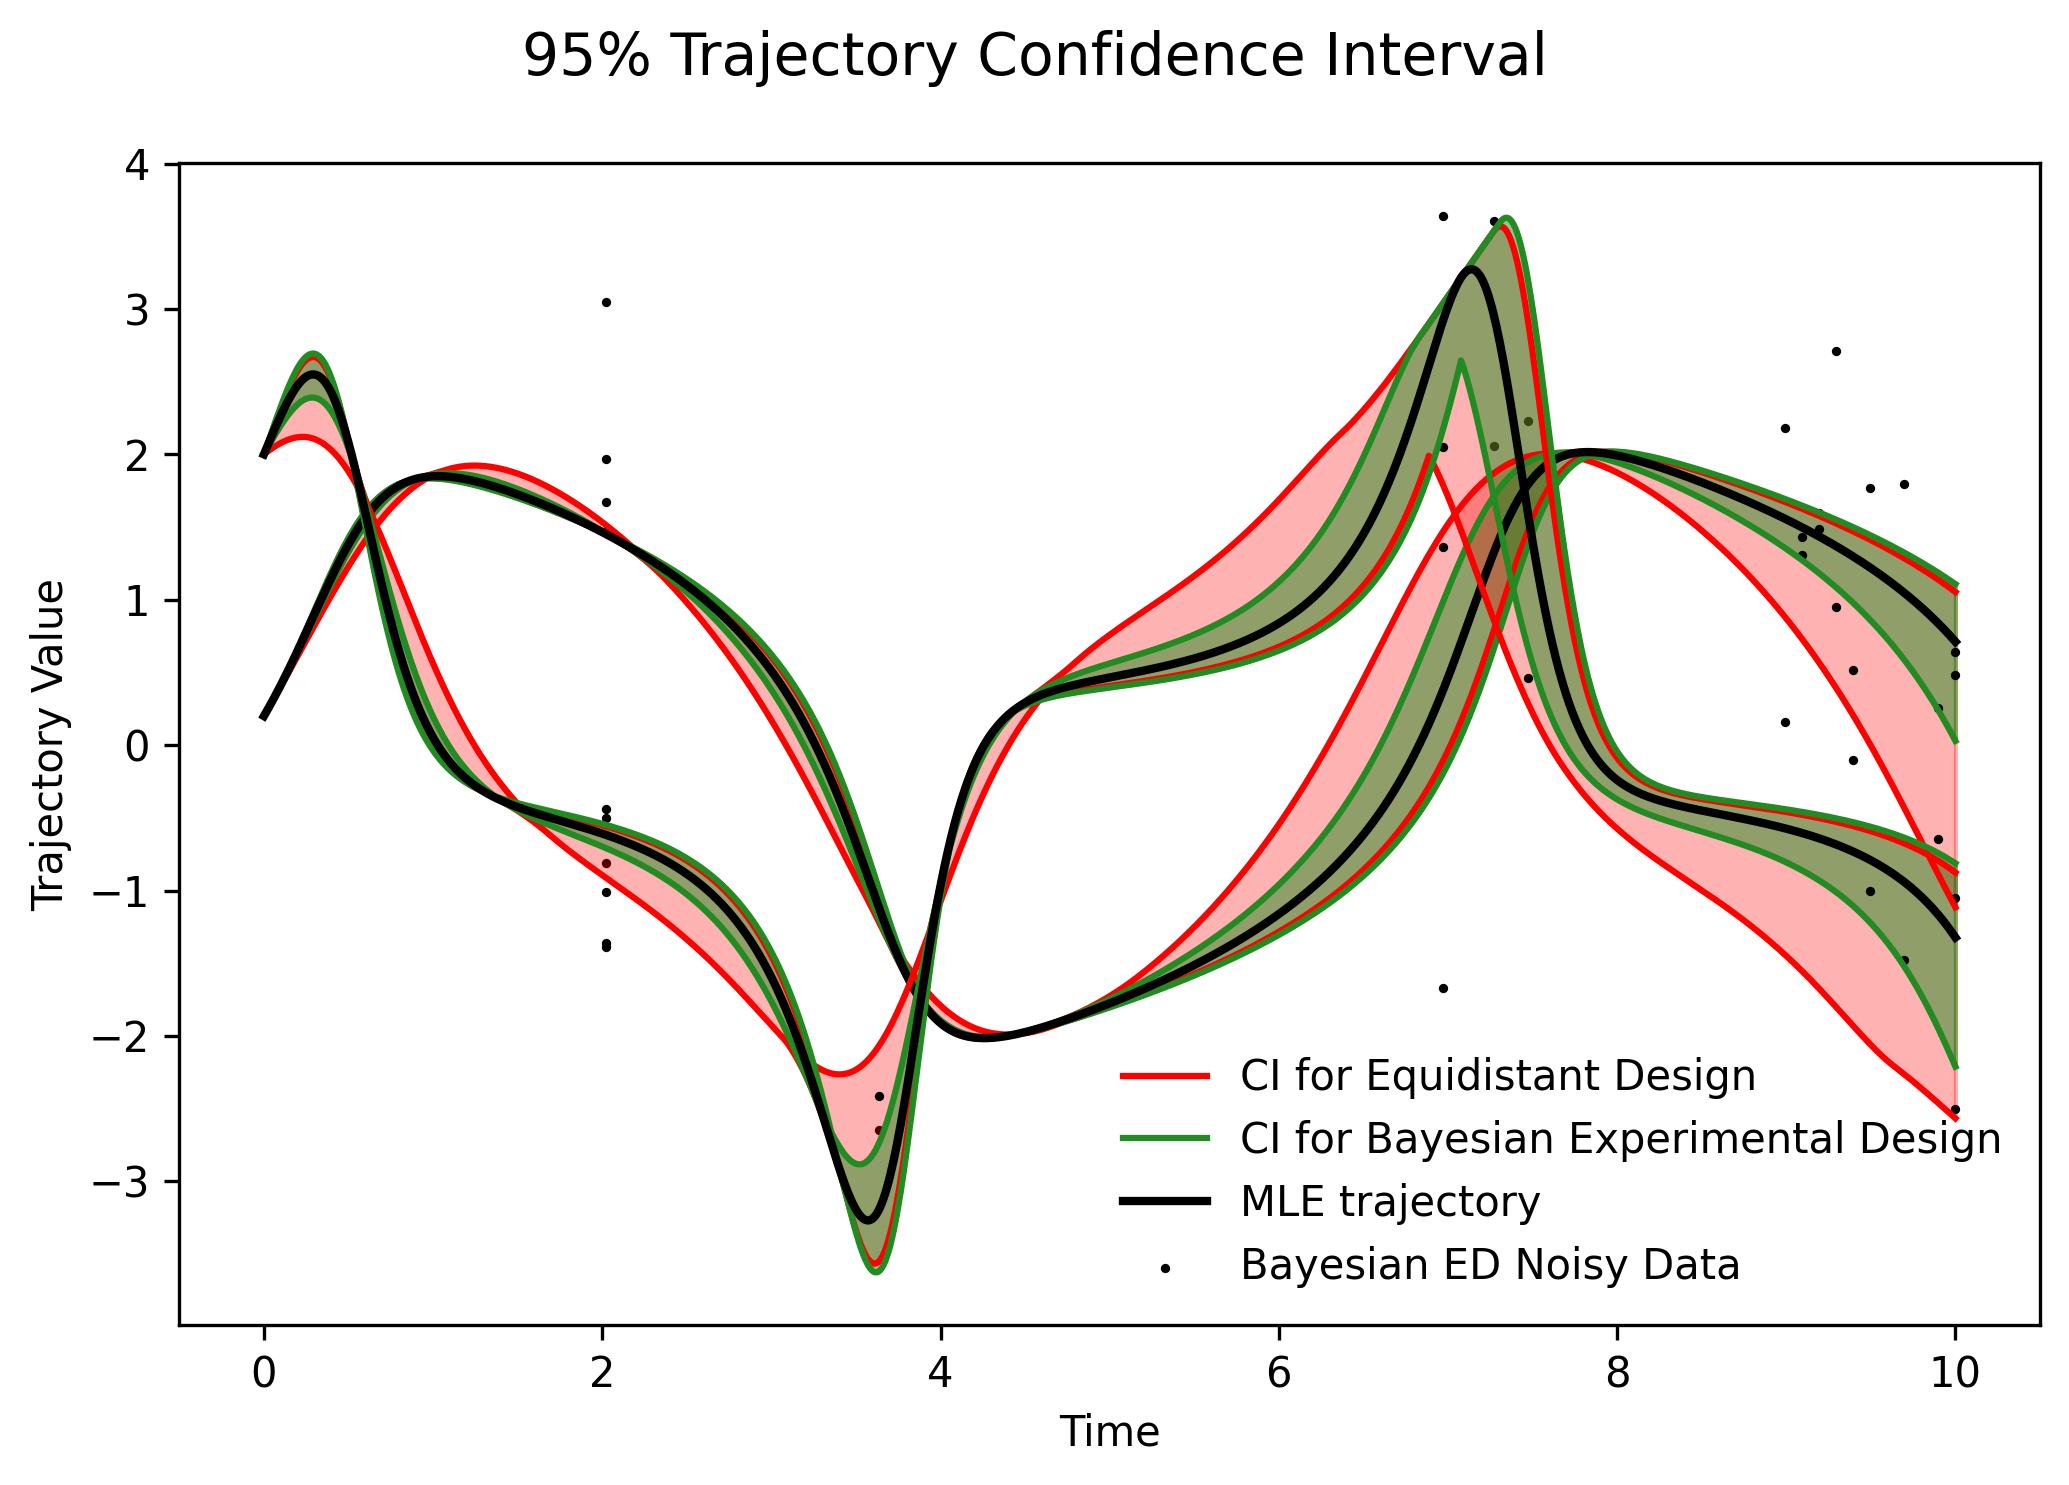

In [430]:
traj_dict = compare_trajectory_CI(split_likelihood_ed, split_likelihood, vector_field, ed_params, n_params, 
                                                        times = jnp.linspace(0, 10, 1000),
                                                        plot = True)
